In [1]:
%pip install kydavra pandas numpy scikit-learn matplotlib seaborn optuna xgboost lightgbm shap tabulate plotly nbformat

Note: you may need to restart the kernel to use updated packages.


### Dataset Description

### Features

| Feature Name                  | Description                                                                                                   | Type      |
|-------------------------------|---------------------------------------------------------------------------------------------------------------|-----------|
| `destination`                 | Type of trip destination (e.g., Bar, Restaurant, CarryAway).                                                  | string    |
| `passanger`                   | Type of traveller (e.g., Alone, Friend(s), Partner, Kids).                                                    | string    |
| `weather`                     | Weather conditions at the time (e.g., Sunny, Rainy, Snowy).                                                   | string    |
| `temperature`                 | Temperature level category (e.g., 30, 50, 80).                                                                | integer   |
| `coupon`                      | Coupon category offered (e.g., CoffeeHouse, RestaurantLessThan20, CarryAway).                                 | string    |
| `expiration`                  | Coupon validity period (e.g., 2h, 1d).                                                                        | string    |
| `gender`                      | Gender of the person.                                                                                         | string    |
| `age`                         | Age of the person.                                                                                            | integer   |
| `maritalStatus`               | Marital status (e.g., Single, Married).                                                                       | string    |
| `has_children`                | Indicates if the person has children (0 = No, 1 = Yes).                                                       | integer   |
| `education`                   | Highest education level (e.g., Some High School, Bachelors, Graduate).                                       | string    |
| `occupation`                  | Type of job or profession.                                                                                    | string    |
| `income`                      | Income range category (e.g., Less than $12,500, $25,000–$50,000).                                             | string    |
| `car`                         | Indicates if the user owns a car.                                                                             | string    |
| `Bar`                         | Frequency of visiting bars (e.g., never, 1~3 times, 4~8 times, >8 times).                                    | string    |
| `CoffeeHouse`                 | Frequency of visiting coffee houses.                                                                         | string    |
| `CarryAway`                   | Frequency of using carry-away services.                                                                      | string    |
| `RestaurantLessThan20`        | Frequency of visiting restaurants with bills under $20.                                                      | string    |
| `Restaurant20To50`            | Frequency of visiting restaurants with bills between $20 and $50.                                            | string    |
| `toCoupon_GEQ5min`            | Whether the destination is at least 5 minutes away.                                                           | integer   |
| `toCoupon_GEQ15min`           | Whether the destination is at least 15 minutes away.                                                          | integer   |
| `toCoupon_GEQ25min`           | Whether the destination is at least 25 minutes away.                                                          | integer   |
| `direction_same`              | Whether the coupon location is in the same direction as the user’s travel route.                              | integer   |
| `direction_opp`               | Whether the coupon location is in the opposite direction from the user’s route.                               | integer   |

### Target

The target variable is `Y` (or sometimes named `accepted_coupon` ), it indicates whether the user accepted the coupon (`1 = yes`, `0 = no`).  
Thus, this is a Supervised Classification Machine Learning Problem.

### Problem Description

This dataset contains information about users, their demographics, travel context, and coupon characteristics. The goal is to predict whether a user will accept a given coupon based on contextual and personal factors such as age, income, weather, and distance to the location.  

It is designed for research and evaluation in behavioral prediction, recommendation systems, and context-aware marketing.

In [2]:
# Import Data Structures
import pandas as pd

# Import Data Manipulation Libraries
import numpy as np
from collections import defaultdict
from typing import List, Tuple, Dict, Any

# Import Base Classes for Type Annotation
from sklearn.base import BaseEstimator, TransformerMixin, clone
from numbers import Number

# Import Structure Manipulation Methods
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

# Import Visualization Libs
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import scipy.sparse as sp
import seaborn as sns
sns.set_style(style="whitegrid")
sns.set_palette('bright')

# Import Hyperparameter Tuning
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import SuccessiveHalvingPruner

# Import ML Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Import Interpretation Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import shap
shap.initjs()

/home/calin/Projects/Sigmoid/exam_v2/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Dataset Loading


In [3]:
coupon_df: pd.DataFrame = pd.read_csv(
    filepath_or_buffer='data/coupon_recommendations.csv'
)
coupon_df.head()

destination  passanger weather  temperature                 coupon  \
0  No Urgent Place      Alone   Sunny           55        Restaurant(<20)   
1  No Urgent Place  Friend(s)   Sunny           80           Coffee House   
2  No Urgent Place  Friend(s)   Sunny           80  Carry out & Take away   
3  No Urgent Place  Friend(s)   Sunny           80           Coffee House   
4  No Urgent Place  Friend(s)   Sunny           80           Coffee House   

  expiration  gender age      maritalStatus  has_children  ... CoffeeHouse  \
0         1d  Female  21  Unmarried partner             1  ...       never   
1         2h  Female  21  Unmarried partner             1  ...       never   
2         2h  Female  21  Unmarried partner             1  ...       never   
3         2h  Female  21  Unmarried partner             1  ...       never   
4         1d  Female  21  Unmarried partner             1  ...       never   

  CarryAway RestaurantLessThan20 Restaurant20To50 toCoupon_GEQ5min  \
0       NaN                  4~8              1~3                1   
1       NaN                  4~8              1~3                1   
2       NaN                  4~8              1~3                1   
3       NaN                  4~8              1~3                1   
4       NaN                  4~8              1~3                1   

  toCoupon_GEQ15min toCoupon_GEQ25min direction_same direction_opp  \
0                 0                 0              0             1   
1                 0                 0              0             1   
2                 1                 0              0             1   
3                 1                 0              0             1   
4                 1                 0              0             1   

   Accept(Y/N?)  
0             1  
1             0  
2             1  
3             0  
4             0  

[5 rows x 25 columns]

### Data Analysis

In [4]:
coupon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   coupon                12684 non-null  object
 5   expiration            12684 non-null  object
 6   gender                12684 non-null  object
 7   age                   12684 non-null  object
 8   maritalStatus         12684 non-null  object
 9   has_children          12684 non-null  int64 
 10  education             12684 non-null  object
 11  occupation            12684 non-null  object
 12  income                12684 non-null  object
 13  car                   108 non-null    object
 14  Bar                   12577 non-null  object
 15  CoffeeHouse           12467 non-null

Having a glance at the dataset, I see that it is made of 24 features, and most of them are of type `object`. Specifically, 16 features are of `object` datatype (in other words, string), and 8 features are numerical (`int64`).  

Most categorical variables represent user or contextual characteristics — such as `destination`, `passanger`, `weather`, `coupon`, and `occupation` — which will require appropriate **encoding techniques** (like one-hot or ordinal encoding) to be transformed into numerical form for model training.  

Additionally, some features, such as `toCoupon_GEQ5min`, `toCoupon_GEQ15min`, and `direction_same`, are binary indicators, already in numeric form and suitable for direct use in modeling.  

No significant missing values are detected in most columns; however, being string-type, **empty strings** might exist and need to be handled as **null equivalents** before preprocessing.  

It is also worth noting that the `car` column contains only **108 non-null entries** across the entire dataset, making it **practically useless** for predictive modeling, as it lacks sufficient data coverage to provide meaningful insights or improve model performance. 


In [5]:
categorical_features: list[str] = []
numerical_features: list[str] = []

for col in coupon_df.columns:
    if coupon_df[col].dtype == 'object':
        print(f"Feature '{col}' has {len(coupon_df[col].unique())} Unique Values: {coupon_df[col].unique()}\n")
        categorical_features.append(col)
    else:
        numerical_features.append(col)

Feature 'destination' has 3 Unique Values: ['No Urgent Place' 'Home' 'Work']

Feature 'passanger' has 4 Unique Values: ['Alone' 'Friend(s)' 'Kid(s)' 'Partner']

Feature 'weather' has 3 Unique Values: ['Sunny' 'Rainy' 'Snowy']

Feature 'coupon' has 5 Unique Values: ['Restaurant(<20)' 'Coffee House' 'Carry out & Take away' 'Bar'
 'Restaurant(20-50)']

Feature 'expiration' has 2 Unique Values: ['1d' '2h']

Feature 'gender' has 2 Unique Values: ['Female' 'Male']

Feature 'age' has 8 Unique Values: ['21' '46' '26' '31' '41' '50plus' '36' 'below21']

Feature 'maritalStatus' has 5 Unique Values: ['Unmarried partner' 'Single' 'Married partner' 'Divorced' 'Widowed']

Feature 'education' has 6 Unique Values: ['Some college - no degree' 'Bachelors degree' 'Associates degree'
 'High School Graduate' 'Graduate degree (Masters or Doctorate)'
 'Some High School']

Feature 'occupation' has 25 Unique Values: ['Unemployed' 'Architecture & Engineering' 'Student'
 'Education&Training&Library' 'Healthcare 

Categorical Feature Summary

The dataset contains a variety of categorical features describing user context, demographics, and coupon details.  
Most features, such as `destination`, `passanger`, `weather`, and `coupon`, have a small number of unique values (2–9), while `occupation` shows the highest diversity with 25 unique categories.  

Several frequency-based features (`Bar`, `CoffeeHouse`, `CarryAway`, `RestaurantLessThan20`, `Restaurant20To50`) include missing values represented as `NaN`.  

The `car` column contains only 108 valid entries across the dataset, making it practically useless for modeling due to insufficient data coverage.  

The analysis confirms that `age` should be treated as an **ordinal variable** (grouped into ranges like $21-25$ or $31-40$) rather than a continuous numeric one.

Overall, the dataset is highly **categorical**, requiring appropriate **encoding** methods before training any predictive models.  


In [6]:
coupon_df[coupon_df.duplicated()]

destination  passanger weather  temperature        coupon  \
30     No Urgent Place  Friend(s)   Sunny           80  Coffee House   
96     No Urgent Place  Friend(s)   Sunny           80  Coffee House   
162    No Urgent Place  Friend(s)   Sunny           80  Coffee House   
184    No Urgent Place  Friend(s)   Sunny           80  Coffee House   
201    No Urgent Place  Friend(s)   Sunny           80  Coffee House   
...                ...        ...     ...          ...           ...   
10454  No Urgent Place     Kid(s)   Sunny           80  Coffee House   
10515  No Urgent Place     Kid(s)   Sunny           80  Coffee House   
10592  No Urgent Place     Kid(s)   Sunny           80  Coffee House   
10670  No Urgent Place     Kid(s)   Sunny           80  Coffee House   
10708  No Urgent Place     Kid(s)   Sunny           80  Coffee House   

      expiration  gender     age    maritalStatus  has_children  ...  \
30            2h    Male      21           Single             0  ...   
96            2h    Male      21           Single             0  ...   
162           2h    Male      26           Single             0  ...   
184           2h  Female      26           Single             1  ...   
201           2h    Male      21           Single             0  ...   
...          ...     ...     ...              ...           ...  ...   
10454         1d  Female      36         Divorced             1  ...   
10515         1d  Female  50plus  Married partner             1  ...   
10592         1d  Female      26  Married partner             1  ...   
10670         1d  Female      26  Married partner             1  ...   
10708         1d  Female      41           Single             1  ...   

      CoffeeHouse CarryAway RestaurantLessThan20 Restaurant20To50  \
30          less1       4~8                  4~8            less1   
96          less1       1~3                less1              1~3   
162           gt8       gt8                  gt8              gt8   
184           1~3       4~8                  1~3            less1   
201         never       gt8                  1~3            less1   
...           ...       ...                  ...              ...   
10454         gt8       4~8                  4~8            less1   
10515         4~8       1~3                  4~8              1~3   
10592       never     less1                less1            less1   
10670       never       1~3                less1            never   
10708       less1       1~3                  1~3            less1   

      toCoupon_GEQ5min toCoupon_GEQ15min toCoupon_GEQ25min direction_same  \
30                   1                 0                 0              0   
96                   1                 0                 0              0   
162                  1                 0                 0              0   
184                  1                 0                 0              0   
201                  1                 0                 0              0   
...                ...               ...               ...            ...   
10454                1                 0                 0              0   
10515                1                 0                 0              0   
10592                1                 0                 0              0   
10670                1                 0                 0              0   
10708                1                 0                 0              0   

      direction_opp  Accept(Y/N?)  
30                1             0  
96                1             1  
162               1             0  
184               1             1  
201               1             0  
...             ...           ...  
10454             1             1  
10515             1             1  
10592             1             0  
10670             1             0  
10708             1             0  

[291 rows x 25 columns]

Although they are not a structural problem (the 291 rows represent only about 2.2% of the 12684 records), it is essential to remove them before building any predictive model to prevent overfitting and ensure that we evaluate the model's performance based on unique observations.

In [7]:
coupon_df.isnull().sum()

destination                 0
passanger                   0
weather                     0
temperature                 0
coupon                      0
expiration                  0
gender                      0
age                         0
maritalStatus               0
has_children                0
education                   0
occupation                  0
income                      0
car                     12576
Bar                       107
CoffeeHouse               217
CarryAway                 151
RestaurantLessThan20      130
Restaurant20To50          189
toCoupon_GEQ5min            0
toCoupon_GEQ15min           0
toCoupon_GEQ25min           0
direction_same              0
direction_opp               0
Accept(Y/N?)                0
dtype: int64

Most columns in the dataset are complete, with only a few containing missing values.  
The `car` feature has almost all values missing and can be safely removed.  
Other columns such as `Bar`, `CoffeeHouse`, `CarryAway`, `RestaurantLessThan20`, and `Restaurant20To50` have small amounts of missing data that can be imputed or treated as a separate category.  
Overall, missing values are minimal and should not significantly affect the analysis.  

### Data Cleaning
In this part we drop collumn car, raname collumn accept and map the age as a range

In [8]:
coupon_df_cleaned = coupon_df.drop_duplicates(keep='first')

In [9]:
coupon_df.drop(columns=['car'], inplace=True)
coupon_df.rename(columns={'Accept(Y/N?)': 'accept_coupon'}, inplace=True)

In [10]:
age_map = {
    "below21": "Below 21",
    "21":      "21-25",
    "26":      "26-30",
    "31":      "31-35",
    "36":      "36-40",
    "41":      "41-45",
    "46":      "46-49",
    "50plus":  "50+",
}

coupon_df["age"] = (
    coupon_df["age"].astype("string").str.strip().replace(age_map)
)

In [11]:
freq_cols = ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']

for col in freq_cols:
    mode_val = coupon_df[col].mode()[0]
    coupon_df[col] = coupon_df[col].fillna(mode_val)
    print(f"Filled NaN in {col} with '{mode_val}'")


Filled NaN in Bar with 'never'
Filled NaN in CoffeeHouse with 'less1'
Filled NaN in CarryAway with '1~3'
Filled NaN in RestaurantLessThan20 with '1~3'
Filled NaN in Restaurant20To50 with 'less1'


In [12]:
coupon_df.isnull().sum()

destination             0
passanger               0
weather                 0
temperature             0
coupon                  0
expiration              0
gender                  0
age                     0
maritalStatus           0
has_children            0
education               0
occupation              0
income                  0
Bar                     0
CoffeeHouse             0
CarryAway               0
RestaurantLessThan20    0
Restaurant20To50        0
toCoupon_GEQ5min        0
toCoupon_GEQ15min       0
toCoupon_GEQ25min       0
direction_same          0
direction_opp           0
accept_coupon           0
dtype: int64

### Exploratory Data Analysis
As an important step in Dataset analysis is EDA (Exploratory Data Analysis) that involves Data Visualization in order to find relationships between features, analyze distributions and other specifics that can be described better and concise using visualization techniques and plots.

because i want my plots to be sorted in ascending order. So I created manual orderings for non-numeric categories (income and age) so my plots display in logical ascending order rather than alphabetical order.

In [13]:
income_order = [
    'Less than $12500', '$12500 - $24999', '$25000 - $37499',
    '$37500 - $49999', '$50000 - $62499', '$62500 - $74999',
    '$75000 - $87499', '$87500 - $99999', '$100000 or More'
]
age_order = ['Below 21', '21-25', '26-30', '31-35', '36-40', '41-45', '46-49', '50+']


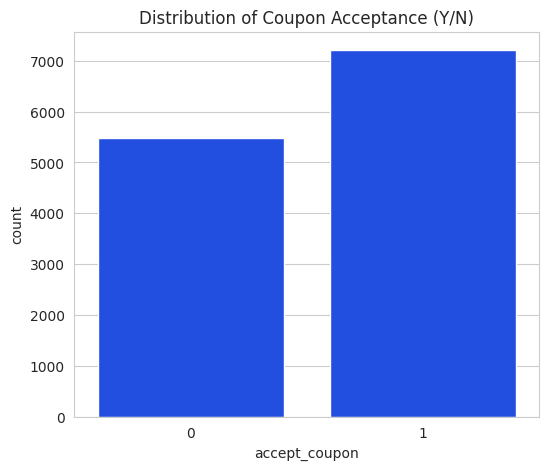

Target Variable Proportions:
 accept_coupon
1    56.843267
0    43.156733
Name: proportion, dtype: float64


In [14]:
plt.figure(figsize=(6, 5))
sns.countplot(x='accept_coupon', data=coupon_df)
plt.title('Distribution of Coupon Acceptance (Y/N)')
plt.show()

# Print proportions
target_proportions = coupon_df['accept_coupon'].value_counts(normalize=True) * 100
print("Target Variable Proportions:\n", target_proportions)

As it may be seen from the bar chart, the target variable accept_coupon exhibits a moderate class imbalance. The category labeled '1' (Yes, accepted the coupon) has a higher frequency, with approximately 7,200 instances, while the category '0' (No, did not accept the coupon) contains around 5,500 instances. 

Based on the calculated proportions, approximately 56.7% of users accepted the coupon, while 43.3% declined it. This indicates that while the dataset is not severely imbalanced, there is a noticeable tendency toward coupon acceptance in this population. Such a distribution should be taken into account during model training, particularly when evaluating performance metrics, to ensure the model does not become biased toward the majority class (acceptance). Techniques such as stratified sampling, resampling, or using appropriate evaluation metrics (e.g., F1-score, precision-recall AUC) may be necessary to address this imbalance effectively. 


Age distribution (%)
age
21-25       20.92
26-30       20.18
31-35       16.08
36-40        10.4
41-45        8.62
46-49        5.41
50+          14.1
Below 21     4.31


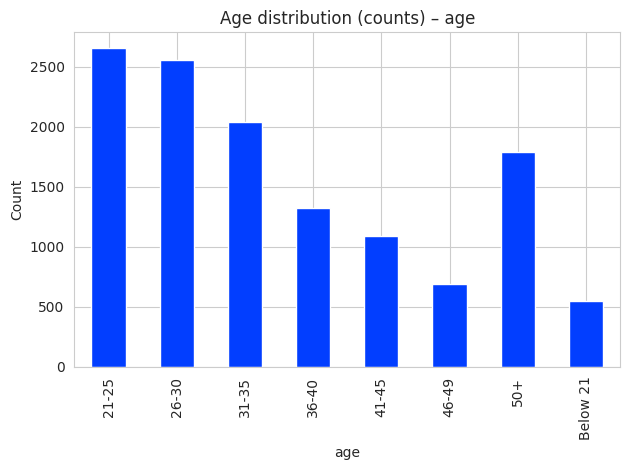

In [15]:
age_col = "age"

# counts plot
age_series = coupon_df[age_col].astype("string")
counts = age_series.value_counts(dropna=False).sort_index()
plt.figure()
cmap = plt.get_cmap('magma')
counts.plot(kind="bar")
plt.title(f"Age distribution (counts) – {age_col}")
plt.ylabel("Count")
plt.tight_layout()

# print percentages to console
perc = (counts / counts.sum() * 100)
print("\nAge distribution (%)")
print(perc.round(2).to_string())


The age distribution is heavily skewed toward younger users, with the 21-25 (20.9%) and 26-30 (20.2%) groups making up over 40% of the dataset. The 31-35 group follows at 16.1%, while older brackets decline steadily, except for 50+, which rebounds at 14.1%, suggesting a secondary user segment. The youngest group (Below 21) is smallest at just 4.3%, reflecting either lower participation or data collection limitations for this demographic.

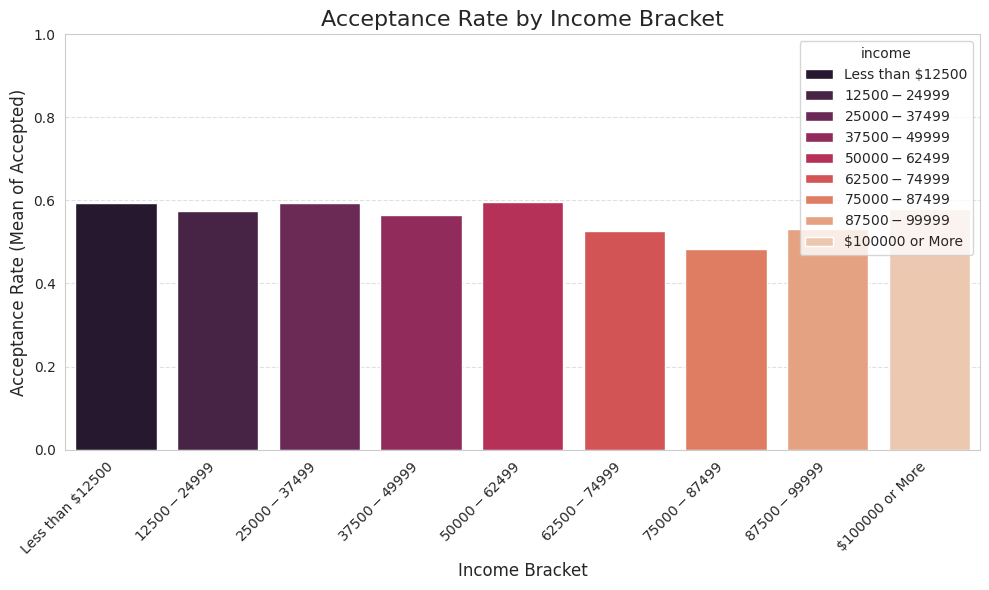

In [16]:
acc = coupon_df['accept_coupon']

income_acceptance_rate = (
    pd.DataFrame({'income': coupon_df['income'], 'acc': acc})
      .groupby('income', dropna=False)['acc']
      .mean()
      .reindex(income_order)
      .reset_index(name='accept_rate')
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=income_acceptance_rate,
    x='income', y='accept_rate',
    hue='income', 
    dodge=False,
    palette='rocket',
    legend=True 
)
plt.title('Acceptance Rate by Income Bracket', fontsize=16)
plt.xlabel('Income Bracket', fontsize=12)
plt.ylabel('Acceptance Rate (Mean of Accepted)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

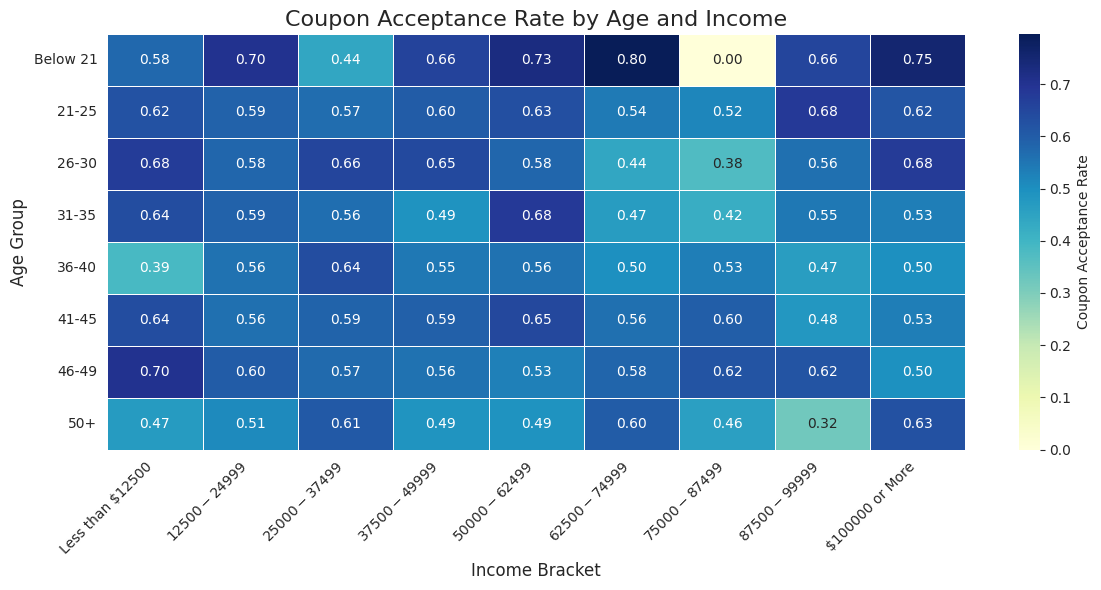

In [17]:
df_plot = coupon_df[['age', 'income']].copy()
df_plot['accept'] = acc

age_order = ['Below 21', '21-25', '26-30', '31-35', '36-40', '41-45', '46-49', '50+']
income_order = [
    'Less than $12500', '$12500 - $24999', '$25000 - $37499',
    '$37500 - $49999', '$50000 - $62499', '$62500 - $74999',
    '$75000 - $87499', '$87500 - $99999', '$100000 or More'
]

acceptance_rates = df_plot.groupby(['age', 'income'])['accept'].mean().unstack(fill_value=0)

# Reindex to ensure correct order
acceptance_rates = acceptance_rates.reindex(index=age_order, columns=income_order)

plt.figure(figsize=(12, 6))
sns.heatmap(
    acceptance_rates,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    cbar_kws={'label': 'Coupon Acceptance Rate'},
    linewidths=0.5
)
plt.title('Coupon Acceptance Rate by Age and Income', fontsize=16)
plt.xlabel('Income Bracket', fontsize=12)
plt.ylabel('Age Group', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

The heatmap reveals nuanced interactions between age and income in coupon acceptance. The highest acceptance rates (up to 0.80) occur among younger users (Below 21, 21-25) with mid-to-high incomes ($50K-$75K) suggesting younger, financially stable users are most responsive. 

Notably, users aged 36-40 show the lowest overall acceptance, especially in mid-income brackets (e.g., 0.39 for <$12.5K). In contrast, older users (50+) with very high income ($100K+) rebound strongly (0.63), while those in the $87.5K–$99.9K range dip sharply (0.32), hinting at possible targeting inefficiencies or behavioral shifts. 

Overall, younger + higher-income and older + top-tier income groups are prime targets, while middle-aged, mid-income users appear least receptive. Segment-specific strategies may be needed to improve engagement across all demographics. 

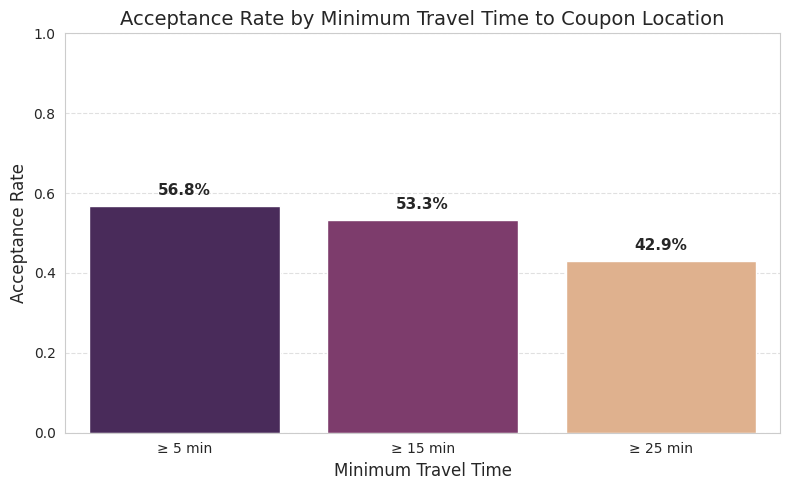

In [18]:
cols = ['toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min']
labels = ['≥ 5 min', '≥ 15 min', '≥ 25 min']

rates = [
    coupon_df[coupon_df[col] == 1]['accept_coupon'].mean()
    for col in cols
]

plt.figure(figsize=(8, 5))
ax = sns.barplot(x=labels, y=rates, palette='flare',hue=rates, legend=False)

for i, rate in enumerate(rates):
    ax.text(i, rate + 0.02, f"{rate*100:.1f}%", ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.title('Acceptance Rate by Minimum Travel Time to Coupon Location', fontsize=14)
plt.xlabel('Minimum Travel Time', fontsize=12)
plt.ylabel('Acceptance Rate', fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Acceptance rates decline as required travel time increases:   
- ≥ 5 min: ~56.8% 
- ≥ 15 min: ~53.3%  
- ≥ 25 min: ~42.9%

This suggests users are significantly less likely to accept coupons that require longer travel. The ~14 percentage-point drop from 5 to 25+ minutes highlights travel time as a key barrier, likely reflecting convenience, time sensitivity, or perceived effort. For maximum uptake, coupons should be offered for nearby or easily accessible locations. 

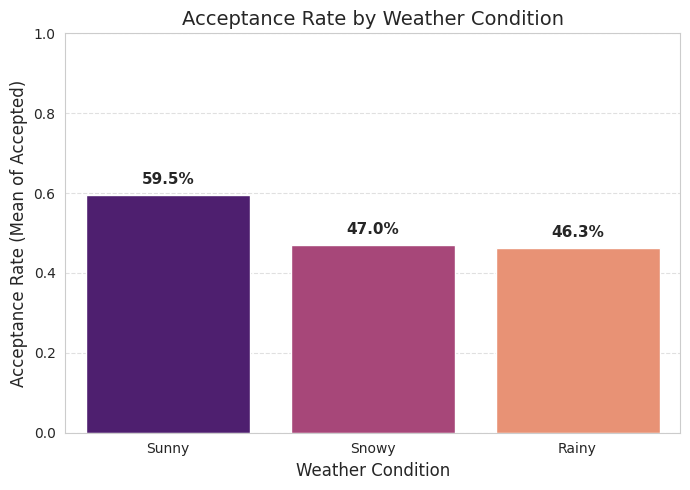

In [19]:
weather_acceptance_rate = coupon_df.groupby('weather')['accept_coupon'].mean().sort_values(ascending=False)

weather_df = weather_acceptance_rate.reset_index(name='Acceptance_Rate')

plt.figure(figsize=(7, 5))
sns.barplot(
    data = weather_df,
    x = 'weather',
    y = 'Acceptance_Rate',
    palette = 'magma',
    hue ='weather',
)
plt.title('Acceptance Rate by Weather Condition', fontsize=14)
plt.xlabel('Weather Condition', fontsize=12)
plt.ylabel('Acceptance Rate (Mean of Accepted)', fontsize=12)
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)

for i, rate in enumerate(weather_df['Acceptance_Rate']):
    plt.text(i, rate + 0.02, f"{rate*100:.1f}%", ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

Users are ~13-14 percentage points more likely to accept coupons on sunny days vs snowy or rainy ones. This suggests weather impacts willingness to travel or engage, making sunny conditions ideal for coupon campaigns. Rain and snow appear similarly discouraging, likely due to reduced mobility or outdoor activity. 

Takeaway: Time promotions with good weather for maximum uptake. 

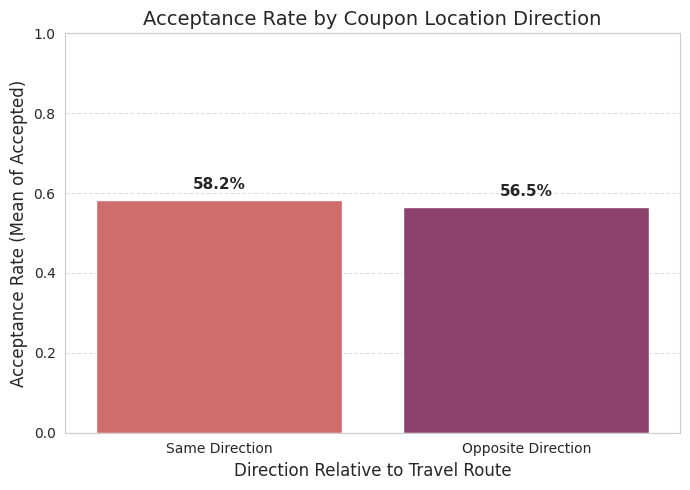

In [20]:
direction_same_rate = coupon_df[coupon_df['direction_same'] == 1]['accept_coupon'].mean()
direction_opp_rate = coupon_df[coupon_df['direction_opp'] == 1]['accept_coupon'].mean()

direction_data = pd.DataFrame({
    'Direction': ['Same Direction', 'Opposite Direction'],
    'Acceptance_Rate': [direction_same_rate, direction_opp_rate]
})

plt.figure(figsize=(7, 5))
sns.barplot(
    x='Direction',
    y='Acceptance_Rate',
    data=direction_data,
    hue='Direction',
    dodge=False,
    palette='flare',
)
plt.title('Acceptance Rate by Coupon Location Direction', fontsize=14)
plt.xlabel('Direction Relative to Travel Route', fontsize=12)
plt.ylabel('Acceptance Rate (Mean of Accepted)', fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)

for i, rate in enumerate(direction_data['Acceptance_Rate']):
    plt.text(i, rate + 0.02, f"{rate*100:.1f}%", ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

Users are slightly more likely to accept coupons when the location is in the same direction as their travel route (58.2%) vs. opposite direction (56.5%). 

The difference is small (~1.7 percentage points), suggesting that while convenience matters, it’s not a major barrier, users still accept coupons even if they require a detour. 

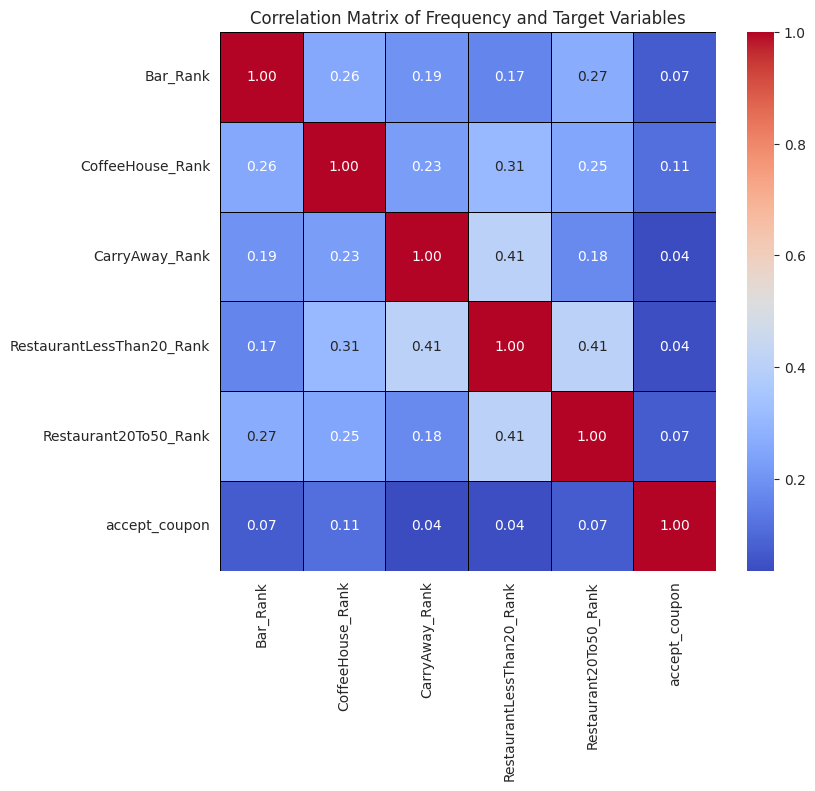

In [21]:
frequency_mapping = {
    'never': 0, 'less1': 1, '1~3': 2, '4~8': 3, 'gt8': 4
}
# Make a copy for correlation analysis
df_corr = coupon_df.copy() 

frequency_cols = [
    'Bar', 'CoffeeHouse', 'CarryAway', 
    'RestaurantLessThan20', 'Restaurant20To50'
]

for col in frequency_cols:
    df_corr[col + '_Rank'] = df_corr[col].map(frequency_mapping)

correlation_features = [col + '_Rank' for col in frequency_cols] + ['accept_coupon']
correlation_matrix = df_corr[correlation_features].corr()

plt.figure(figsize=(8, 7))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap='coolwarm', 
    fmt=".2f", 
    linewidths=.5, 
    linecolor='black'
)
plt.title('Correlation Matrix of Frequency and Target Variables')
plt.show()

All venue frequency features show very weak positive correlation with coupon acceptance, none exceed 0.11. 

This suggests that how often a user visits bars, coffee houses, or restaurants has little predictive power for whether they’ll accept a coupon. Even strong correlations between venues (e.g., CoffeeHouse and RestaurantLessThan20 = 0.31) don’t translate to influence on acceptance. 

In [22]:
for col in frequency_cols:
    df_corr[col + '_Rank'] = df_corr[col].map(frequency_mapping)

# Combine: simple average of all venue frequencies
df_corr['Avg_Frequency'] = df_corr[[col + '_Rank' for col in frequency_cols]].mean(axis=1)

# Optional: check correlation of combined feature with target
print("Correlation of Avg_Frequency with accept_coupon:",
      df_corr['Avg_Frequency'].corr(df_corr['accept_coupon']).round(3))

Correlation of Avg_Frequency with accept_coupon: 0.108


even the combined Avg_Frequency only has a weak correlation (0.108) with coupon acceptance, confirming your earlier heatmap insight

In [23]:
def add_data_labels(ax):
    """Adds the label (the 'Yes' acceptance percentage) to the top section of each bar."""
    for rect in ax.patches:
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()

        if y > 0 and height > 0:
            percentage = f'{height:.1f}%'
            ax.text(x + width / 2, y + height / 2, percentage, ha='center', va='center', color='black', fontweight='bold', fontsize=10)

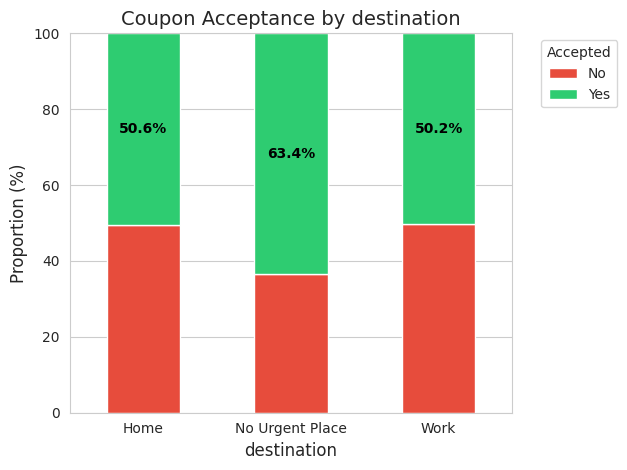

In [24]:
feature = 'destination'
cross_tab = pd.crosstab(coupon_df[feature], coupon_df['accept_coupon'], normalize='index') * 100

ax = cross_tab.plot(kind='bar', stacked=True, color=['#e74c3c', '#2ecc71'])
ax.set_ylim(0, 100)
add_data_labels(ax)
plt.title(f'Coupon Acceptance by {feature}', fontsize=14)
plt.xlabel(feature, fontsize=12)
plt.ylabel('Proportion (%)', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Accepted', labels=['No', 'Yes'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

- “No Urgent Place” has the highest acceptance rate (63.4%) → users are more open to coupons when not rushing.
- “Home” and “Work” are neutral (~50%) → likely routine-driven, less flexible

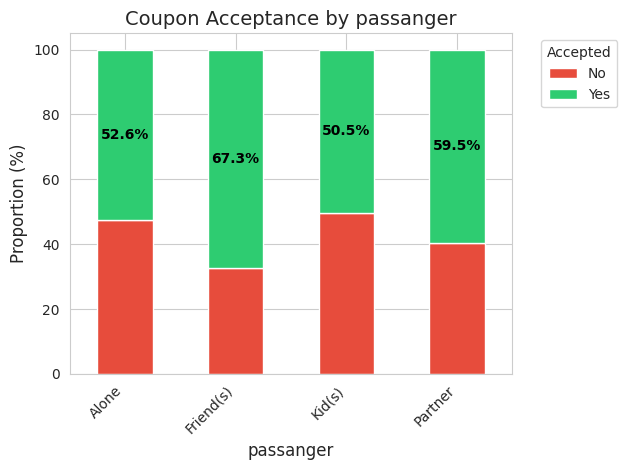

In [25]:
feature = 'passanger'
cross_tab = pd.crosstab(coupon_df[feature], coupon_df['accept_coupon'], normalize='index') * 100

ax = cross_tab.plot(kind='bar', stacked=True, color=['#e74c3c', '#2ecc71'])
add_data_labels(ax)
plt.title(f'Coupon Acceptance by {feature}', fontsize=14)
plt.xlabel(feature, fontsize=12)
plt.ylabel('Proportion (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Accepted', labels=['No', 'Yes'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Key takeaway: Users traveling with friends or partners are significantly more likely to accept coupons, likely due to social decision-making, shared cost, or spontaneous plans.

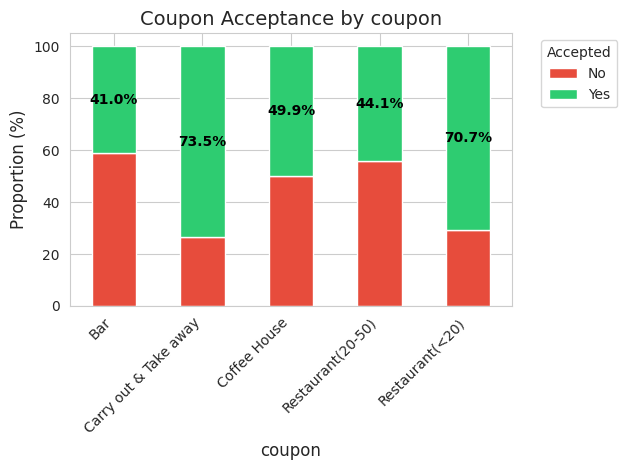

In [26]:
feature = 'coupon'
cross_tab = pd.crosstab(coupon_df[feature], coupon_df['accept_coupon'], normalize='index') * 100

ax = cross_tab.plot(kind='bar', stacked=True, color=['#e74c3c', '#2ecc71'])
add_data_labels(ax)
plt.title(f'Coupon Acceptance by {feature}', fontsize=14)
plt.xlabel(feature, fontsize=12)
plt.ylabel('Proportion (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Accepted', labels=['No', 'Yes'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Key Takeaway: Coupons for Carry out & Take away (73.5%) and Restaurant(<20) (70.7%) are overwhelmingly accepted. Coupons for Bars (41.0%) and Coffee Houses (49.9%) have the lowest acceptance rates, suggesting customers value convenience and cheaper meal options more than leisure/social-venue discounts.

<Figure size 600x500 with 0 Axes>

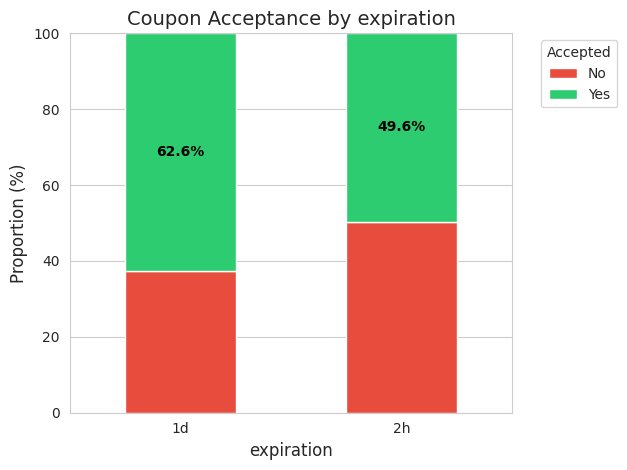

In [27]:
# 5. Plot pentru EXPIRATION
feature = 'expiration'
cross_tab = pd.crosstab(coupon_df[feature], coupon_df['accept_coupon'], normalize='index') * 100

plt.figure(figsize=(6, 5))
ax = cross_tab.plot(kind='bar', stacked=True, color=['#e74c3c', '#2ecc71'])
ax.set_ylim(0, 100)
add_data_labels(ax) # Adaugă etichetele
plt.title(f'Coupon Acceptance by {feature}', fontsize=14)
plt.xlabel(feature, fontsize=12)
plt.ylabel('Proportion (%)', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Accepted', labels=['No', 'Yes'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

As axpected the longer the expiration time, the higher the chance to be accepted

<Figure size 600x500 with 0 Axes>

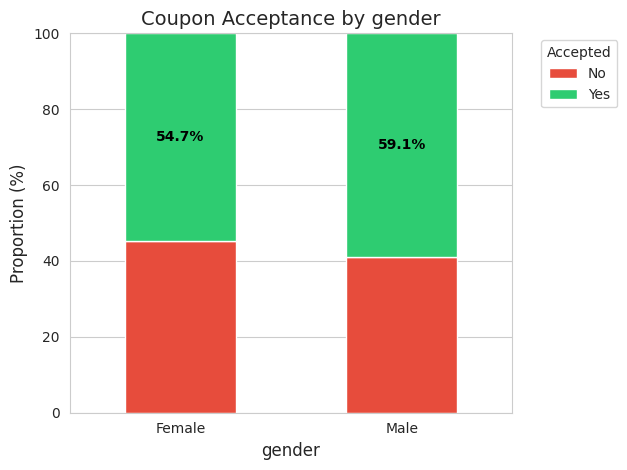

In [28]:
feature = 'gender'
cross_tab = pd.crosstab(coupon_df[feature], coupon_df['accept_coupon'], normalize='index') * 100

plt.figure(figsize=(6, 5))
ax = cross_tab.plot(kind='bar', stacked=True, color=['#e74c3c', '#2ecc71'])
ax.set_ylim(0, 100)
add_data_labels(ax)
plt.title(f'Coupon Acceptance by {feature}', fontsize=14)
plt.xlabel(feature, fontsize=12)
plt.ylabel('Proportion (%)', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Accepted', labels=['No', 'Yes'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

not a lot of difference, just 5% more on the males. This suggests that gender, on its own, is a weak predictor of coupon acceptance.

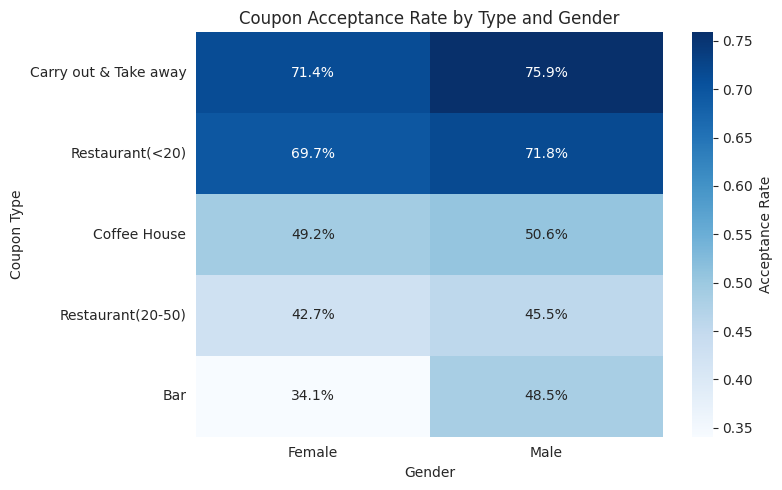

In [29]:
# Compute acceptance rate per (coupon, gender) group
heatmap_data = coupon_df.groupby(['coupon', 'gender'])['accept_coupon'].mean().unstack()

# Optional: reorder coupon types by overall popularity or acceptance
coupon_order = ['Carry out & Take away', 'Restaurant(<20)', 'Coffee House', 
                'Restaurant(20-50)', 'Bar']  # adjust names to match your data
if all(c in heatmap_data.index for c in coupon_order):
    heatmap_data = heatmap_data.reindex(coupon_order)

plt.figure(figsize=(8, 5))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".1%",
    cmap='Blues',
    cbar_kws={'label': 'Acceptance Rate'}
)
plt.title('Coupon Acceptance Rate by Type and Gender')
plt.xlabel('Gender')
plt.ylabel('Coupon Type')
plt.tight_layout()
plt.show()

Key Takeaway: While Males consistently show a higher acceptance rate across all five coupon types, the most significant predictive factor remains the Coupon Type.

- Most Accepted: Carry out & Take away (71.4% for Females, 75.9% for Males) and Restaurant(<20) (69.7% for Females, 71.8% for Males) remain the most popular for both genders.

- Least Accepted: Bar coupons have the lowest acceptance rate overall, but the difference between genders is most pronounced here: Males (48.5%) accept Bar coupons at a significantly higher rate than Females (34.1%), highlighting a strong gender-coupon type interaction for this category.

- Weakest Predictors: Coupons for Coffee House and Restaurant(20-50) show the smallest difference in acceptance between the genders.

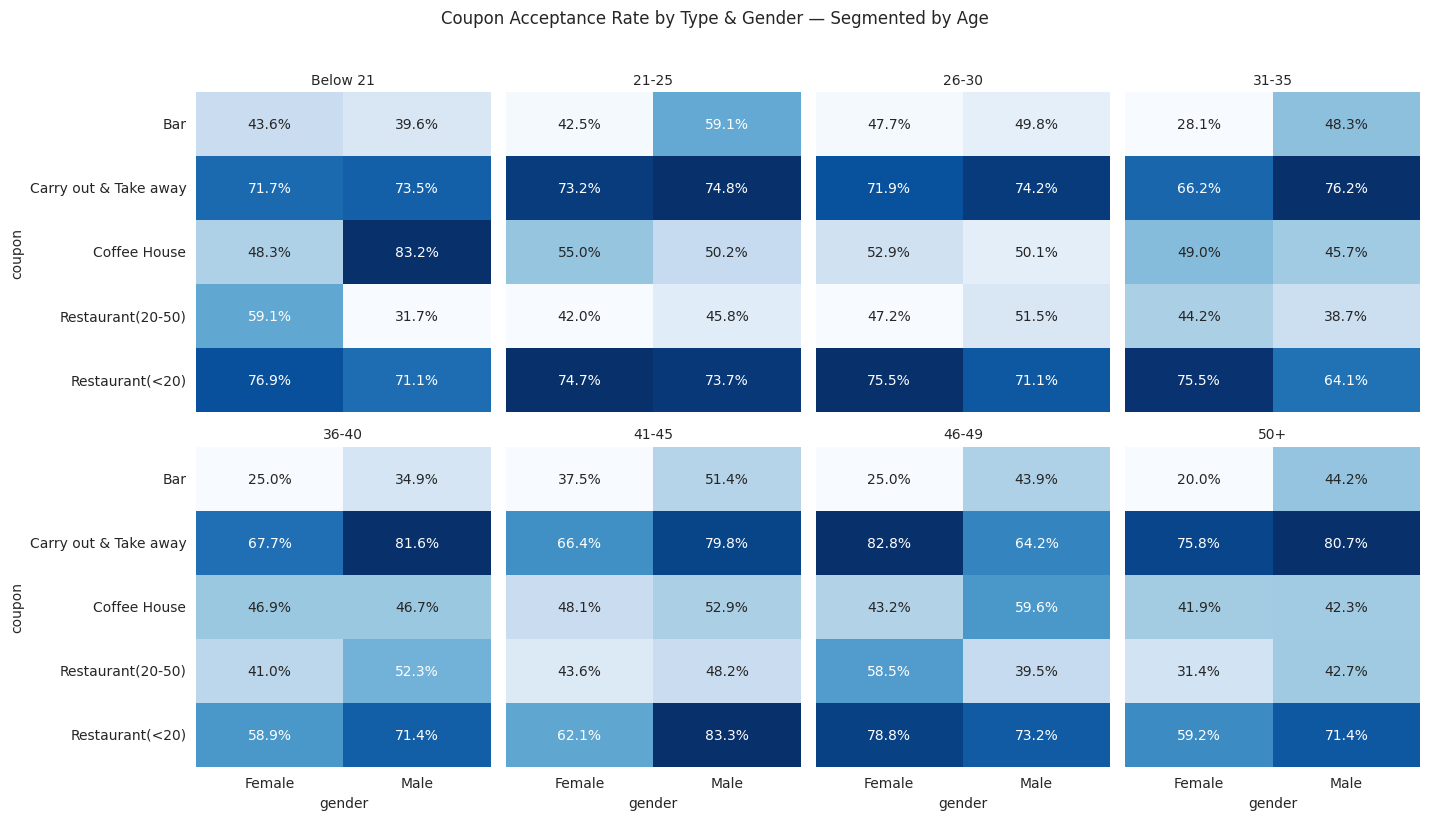

In [30]:
# Make sure 'age' is categorical with order
age_order = ['Below 21', '21-25', '26-30', '31-35', '36-40', '41-45', '46-49', '50+']
coupon_df['age'] = pd.Categorical(coupon_df['age'], categories=age_order, ordered=True)

# Create facets: one heatmap per age group
g = sns.FacetGrid(coupon_df, col='age', col_wrap=4, height=4, aspect=0.9)
g.map_dataframe(
    lambda data, **kws: sns.heatmap(
        data.groupby(['coupon', 'gender'])['accept_coupon'].mean().unstack(),
        annot=True, fmt=".1%", cmap='Blues', cbar=False, **kws
    )
)
g.set_titles(col_template='{col_name}')
g.fig.suptitle('Coupon Acceptance Rate by Type & Gender — Segmented by Age', y=1.02)
plt.tight_layout()
plt.show()

Young adults (21-25) are most responsive overall
- Especially males: 74.8% for CarryOut, 73.7% for Restaurant(<20), 59.1% for Bar. 

Gender gaps vary by age & coupon type   
    In Bar: Males accept more than females in all age groups, strongest gap in 26-30 (49.8% vs 47.7%) and 50+ (44.2% vs 20.0%).
    In Coffee House: Females often lead in younger groups (e.g., Below 21: 48.3% vs 83.2%)
        

Older users (50+) show strong gender polarization
- Males dominate in CarryOut (80.7%), Restaurant(<20) (71.4%), and Bar (44.2%).
- Females drop sharply, especially in Bar (20.0%) and CoffeeHouse (42.3%). 

Restaurant(<20) is universally popular
- Highest acceptance across almost all segments, especially among young and middle-aged users. 

CarryOut & Takeaway peaks in 46-49 group
- 82.8% (F) / 64.2% (M) - suggests mid-life users value convenience. 
     

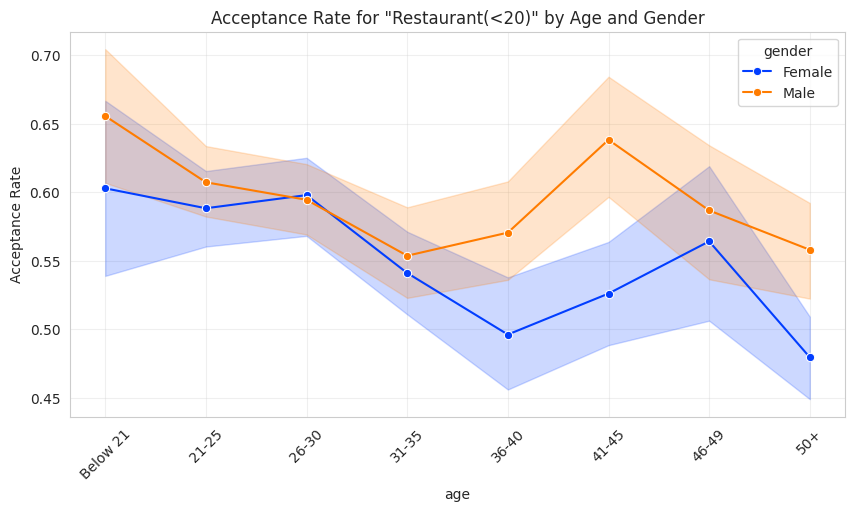

In [31]:
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=coupon_df,
    x='age',
    y='accept_coupon',
    hue='gender',
    estimator='mean',
    marker='o'
)
plt.title('Acceptance Rate for "Restaurant(<20)" by Age and Gender')
plt.ylabel('Acceptance Rate')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

Key Insights: 

- Overall high acceptance: Rates hover between 50-70%, confirms this is a popular coupon type.
- Peak at 41-45 for males (64%), then declines slightly.
- Females show more stability, steady around 55-60%, with a dip at 36-40 (≈50%) and recovery at 46-49.
- Youngest group (Below 21): Males accept more (65%) than females (60%).
- Oldest group (50+): Both genders drop, but males still outperform females (56% vs 48%).
    

This suggests mid-life males are the sweet spot for cheap restaurant coupons, possibly due to budget awareness or social habits. 
     

### Outlier detection

In [32]:
categorical_features: list[str] = []
numerical_features: list[str] = []

for col in coupon_df.columns:
    if coupon_df[col].dtype == 'object':
        print(f"Feature '{col}' has {len(coupon_df[col].unique())} Unique Values: {coupon_df[col].unique()}\n")
        categorical_features.append(col)
    else:
        print(f"Feature '{col}' has {len(coupon_df[col].unique())} Unique Values: {coupon_df[col].unique()}\n")
        numerical_features.append(col)

Feature 'destination' has 3 Unique Values: ['No Urgent Place' 'Home' 'Work']

Feature 'passanger' has 4 Unique Values: ['Alone' 'Friend(s)' 'Kid(s)' 'Partner']

Feature 'weather' has 3 Unique Values: ['Sunny' 'Rainy' 'Snowy']

Feature 'temperature' has 3 Unique Values: [55 80 30]

Feature 'coupon' has 5 Unique Values: ['Restaurant(<20)' 'Coffee House' 'Carry out & Take away' 'Bar'
 'Restaurant(20-50)']

Feature 'expiration' has 2 Unique Values: ['1d' '2h']

Feature 'gender' has 2 Unique Values: ['Female' 'Male']

Feature 'age' has 8 Unique Values: ['21-25', '46-49', '26-30', '31-35', '41-45', '50+', '36-40', 'Below 21']
Categories (8, object): ['Below 21' < '21-25' < '26-30' < '31-35' < '36-40' < '41-45' < '46-49' < '50+']

Feature 'maritalStatus' has 5 Unique Values: ['Unmarried partner' 'Single' 'Married partner' 'Divorced' 'Widowed']

Feature 'has_children' has 2 Unique Values: [1 0]

Feature 'education' has 6 Unique Values: ['Some college - no degree' 'Bachelors degree' 'Associates

At first glance, data is all categorial and we dont have outliers. But cannot definitively say there are no outliers. but the feature `toCoupon_GEQ5min` is constant in training needs to be removed


In [33]:
coupon_df = coupon_df.drop(columns=['toCoupon_GEQ5min'])

In [34]:
import pandas as pd
import numpy as np

# --- 1. Load the data ---
# Make sure your file is in the same directory as your notebook.
df = pd.read_csv("data/coupon_recommendations.csv")

# --- 2. Remove the 'car' column (as per previous steps) ---
if 'car' in df.columns:
    df = df.drop(columns=['car'])

# --- 3. Function to Group Rare Categories (The Outlier Handling Method) ---
def group_rare_categories(df, threshold=0.05):
    """
    Groups categories in 'object' dtype columns that are below a certain
    frequency threshold into a single 'Other' category.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - threshold (float): The maximum proportion a category can have to be considered 'rare'.

    Returns:
    - pd.DataFrame: The DataFrame with rare categories grouped.
    """
    df_cleaned = df.copy()
    # Select only the categorical columns (object dtype)
    object_cols = df_cleaned.select_dtypes(include=['object']).columns

    print(f"Applying rare category grouping with a threshold of {threshold*100}%.")
    
    for col in object_cols:
        # Calculate the frequency of each category
        # normalize=True gives proportions
        value_counts = df_cleaned[col].value_counts(normalize=True, dropna=False)
        
        # Identify categories whose frequency is below the threshold
        rare_categories = value_counts[value_counts < threshold].index.tolist()

        if rare_categories:
            # Replace rare categories with 'Other'
            df_cleaned[col] = df_cleaned[col].replace(rare_categories, 'Other')
            print(f"- {col}: Grouped {len(rare_categories)} rare categories into 'Other'.")
        
    return df_cleaned

# --- 4. Execute the Grouping ---
df_processed = group_rare_categories(df, threshold=0.05)

# --- 5. Verification (Optional but Recommended) ---
print("\n--- Verification of Changes ---")

# Check a column like 'maritalStatus' where 'Widowed' and 'Divorced' were rare
print("\nProcessed 'maritalStatus' counts:")
print(df_processed['maritalStatus'].value_counts(normalize=True))

# Check 'occupation' where many rare categories were grouped
print("\nProcessed 'occupation' counts (Top 5):")
print(df_processed['occupation'].value_counts(normalize=True).head())

del df_processed, df   # remove references
import gc; gc.collect()  # ask Python to reclaim memory
# Now 'df_processed' is ready for your modeling steps (e.g., one-hot encoding).

Applying rare category grouping with a threshold of 5.0%.
- age: Grouped 1 rare categories into 'Other'.
- maritalStatus: Grouped 2 rare categories into 'Other'.
- education: Grouped 1 rare categories into 'Other'.
- occupation: Grouped 18 rare categories into 'Other'.
- Bar: Grouped 2 rare categories into 'Other'.
- CoffeeHouse: Grouped 1 rare categories into 'Other'.
- CarryAway: Grouped 2 rare categories into 'Other'.
- RestaurantLessThan20: Grouped 2 rare categories into 'Other'.
- Restaurant20To50: Grouped 2 rare categories into 'Other'.

--- Verification of Changes ---

Processed 'maritalStatus' counts:
maritalStatus
Married partner      0.402081
Single               0.374645
Unmarried partner    0.172343
Other                0.050930
Name: proportion, dtype: float64

Processed 'occupation' counts (Top 5):
occupation
Other                      0.339719
Unemployed                 0.147430
Student                    0.124882
Computer & Mathematical    0.111006
Sales & Related      

5746

the thresolds is to big lets lower it to 1% because we lose data. especially in occupation. Grouping them loses valuable patterns about user behavior

In [35]:
print("=== Checking for Rare Categories ===\n")

for col in coupon_df.columns:
    if col == 'accept_coupon':
        continue
    
    value_counts = coupon_df[col].value_counts()
    percentages = (value_counts / len(coupon_df) * 100).round(2)

    rare_categories = percentages[percentages < 1.0]
    
    if len(rare_categories) > 0:
        print(f"Feature '{col}' has rare categories (<1% of data):")
        print(rare_categories)
        print()

=== Checking for Rare Categories ===

Feature 'education' has rare categories (<1% of data):
education
Some High School    0.69
Name: count, dtype: float64

Feature 'occupation' has rare categories (<1% of data):
occupation
Production Occupations                       0.87
Building & Grounds Cleaning & Maintenance    0.35
Farming Fishing & Forestry                   0.34
Name: count, dtype: float64



In [36]:
rare_categories = {
    'occupation': [
        'Production Occupations',
        'Building & Grounds Cleaning & Maintenance',
        'Farming Fishing & Forestry'
    ]
}

# Group them
for column, rare_values in rare_categories.items():
    n_affected = coupon_df[column].isin(rare_values).sum()
    coupon_df[column] = coupon_df[column].replace(rare_values, f'Other_{column.capitalize()}')
    print(f"{column}: Grouped {len(rare_values)} rare categories affecting {n_affected} rows")


occupation: Grouped 3 rare categories affecting 197 rows


### Data Transformation
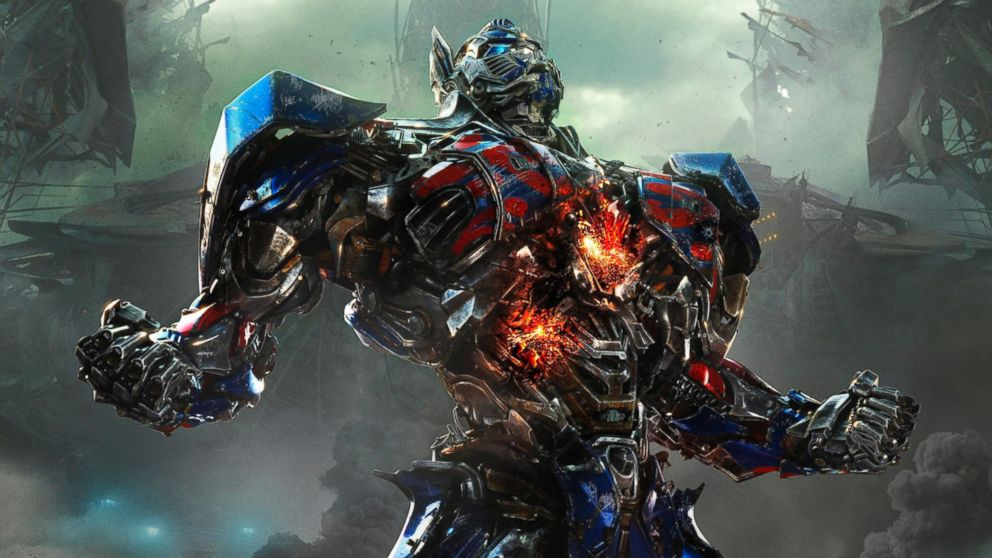

In [37]:
# class DataCleaner(BaseEstimator, TransformerMixin):
#     """Data cleaner that drops duplicates and tracks indices"""
    
#     def __init__(self):
#         self.modes_ = {}
#         self.rare_categories_ = {
#             'occupation': [
#                 'Production Occupations',
#                 'Building & Grounds Cleaning & Maintenance',
#                 'Farming Fishing & Forestry'
#             ]
#         }
#         self.retained_indices_ = None
    
#     def fit(self, X, y=None):
#         freq_cols = ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']
#         for col in freq_cols:
#             if col in X.columns:
#                 self.modes_[col] = X[col].mode()[0] if not X[col].mode().empty else 'never'
#         return self
    
#     def transform(self, X):
#         X_clean = X.copy()

#         # Other operations
#         X_clean = X_clean.drop(columns=['car', 'toCoupon_GEQ5min'], errors='ignore')
        
#         if 'Accept(Y/N?)' in X_clean.columns:
#             X_clean = X_clean.rename(columns={'Accept(Y/N?)': 'accept_coupon'})
        
#         for col, mode_val in self.modes_.items():
#             if col in X_clean.columns:
#                 X_clean[col] = X_clean[col].fillna(mode_val)
        
#         for column, rare_values in self.rare_categories_.items():
#             if column in X_clean.columns:
#                 X_clean[column] = X_clean[column].replace(rare_values, f'Other_{column.capitalize()}')
        
#         return X_clean

# # Then use this in your pipeline and manually align y during evaluation

In [38]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    """Feature engineering steps"""
    def __init__(self):
        self.freq_mapping = {'never': 0, 'less1': 1, '1~3': 2, '4~8': 3, 'gt8': 4}
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_eng = X.copy()
        
        # Create frequency scores
        for col in ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']:
            if col in X_eng.columns:
                X_eng[f'{col}_score'] = X_eng[col].map(self.freq_mapping)
        
        # Create aggregated scores
        if all(col in X_eng.columns for col in ['RestaurantLessThan20_score', 'Restaurant20To50_score']):
            X_eng['total_dining_score'] = X_eng['RestaurantLessThan20_score'] + X_eng['Restaurant20To50_score']
        
        if all(col in X_eng.columns for col in ['Bar_score', 'CoffeeHouse_score']):
            X_eng['total_social_score'] = X_eng['Bar_score'] + X_eng['CoffeeHouse_score']
        
        if all(col in X_eng.columns for col in ['Bar_score', 'CoffeeHouse_score', 'CarryAway_score', 'RestaurantLessThan20_score', 'Restaurant20To50_score']):
            X_eng['total_activity_score'] = (
                X_eng['Bar_score'] + X_eng['CoffeeHouse_score'] + X_eng['CarryAway_score'] +
                X_eng['RestaurantLessThan20_score'] + X_eng['Restaurant20To50_score']
            )
        
        # Coupon matching features
        if all(col in X_eng.columns for col in ['coupon', 'Bar_score']):
            X_eng['coupon_matches_bar'] = (
                (X_eng['coupon'] == 'Bar') & (X_eng['Bar_score'] >= 2)
            ).astype(int)
        
        # Contextual features
        if 'destination' in X_eng.columns:
            X_eng['is_leisure_trip'] = (X_eng['destination'] == 'No Urgent Place').astype(int)
        
        if 'passanger' in X_eng.columns:
            X_eng['is_with_company'] = (~X_eng['passanger'].isin(['Alone'])).astype(int)
        
        if 'weather' in X_eng.columns:
            X_eng['good_weather'] = (X_eng['weather'] == 'Sunny').astype(int)
        
        # Convenience features
        if all(col in X_eng.columns for col in ['direction_same', 'toCoupon_GEQ25min']):
            X_eng['convenience_score'] = X_eng['direction_same'] * 2 + (1 - X_eng['toCoupon_GEQ25min'])
        
        return X_eng

This class creates new features from the coupon dataset to help the model learn better.

- It converts frequency words (like "never", "1~3") into **numeric scores**.  
- Then it adds up related columns to make **total scores**:
  - `total_dining_score` restaurant-related activity  
  - `total_social_score` bar and coffee activity  
  - `total_activity_score` all activity combined  
- It creates **behavioral flags**, such as:
  - `coupon_matches_bar` = when a user who goes to bars often gets a bar coupon  
  - `is_leisure_trip` if destination is “No Urgent Place”  
  - `is_with_company` if not traveling alone  
  - `good_weather` if it’s sunny  
- Finally, it adds a **convenience score** that combines direction and travel time.

**In short:** this transformer converts text-based behavior info into useful numeric and logical features that make user behavior easier for a model to understand.


In [39]:
# Define feature categories
ORDINAL_FEATURES = ['age', 'education', 'income', 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']

AGE_ORDER = ['Below 21', '21-25', '26-30', '31-35', '36-40', '41-45', '46-49', '50+']
EDUCATION_ORDER = [
    'Some High School', 'High School Graduate', 'Some college - no degree',
    'Associates degree', 'Bachelors degree', 'Graduate degree (Masters or Doctorate)'
]
INCOME_ORDER = [
    'Less than $12500', '$12500 - $24999', '$25000 - $37499', '$37500 - $49999',
    '$50000 - $62499', '$62500 - $74999', '$75000 - $87499', '$87500 - $99999',
    '$100000 or More'
]
FREQUENCY_ORDER = ['never', 'less1', '1~3', '4~8', 'gt8']

ORDERING = [
    AGE_ORDER, EDUCATION_ORDER, INCOME_ORDER,
    FREQUENCY_ORDER, FREQUENCY_ORDER, FREQUENCY_ORDER, FREQUENCY_ORDER, FREQUENCY_ORDER
]

NOMINAL_FEATURES = ['destination', 'passanger', 'weather', 'coupon', 'expiration', 'gender', 'maritalStatus', 'occupation']

NUMERIC_FEATURES = ['temperature']

BINARY_FEATURES = ['has_children', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same', 'direction_opp']

ENGINEERED_FEATURES = ['total_dining_score', 'total_social_score', 'total_activity_score', 
                      'coupon_matches_bar', 'is_leisure_trip', 'is_with_company', 
                      'good_weather', 'convenience_score']

In [40]:
preprocessing_transformer = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories=ORDERING, handle_unknown='use_encoded_value', unknown_value=-1), ORDINAL_FEATURES),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'), NOMINAL_FEATURES),
        ('num', StandardScaler(), NUMERIC_FEATURES)
    ],
    remainder='passthrough',
)

full_pipeline = Pipeline([
    ('feature_engineer', FeatureEngineer()),
    ('preprocessor', preprocessing_transformer)
])

This pipeline first applies feature engineering to create new behavioral and contextual features, then uses a ColumnTransformer to encode categorical variables, scale numeric ones, and pass through the rest.
It ensures all data types are properly transformed and ready for model training in one unified preprocessing step.

In [41]:
full_pipeline

Pipeline(steps=[('feature_engineer', FeatureEngineer()),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  OrdinalEncoder(categories=[['Below '
                                                                              '21',
                                                                              '21-25',
                                                                              '26-30',
                                                                              '31-35',
                                                                              '36-40',
                                                                              '41-45',
                                                                              '46-49',
                                                                              '50+'],
                                                                             ['Some '
                                                                              'High '
                                                                              'School',
                                                                              'High '
                                                                              'School '
                                                                              'Graduate',
                                                                              'Some '
                                                                              'college '
                                                                              '- '
                                                                              'no '
                                                                              'degree',
                                                                              'Associates '
                                                                              'degree',
                                                                              'Bachelors '
                                                                              'degree',
                                                                              'G...
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['age', 'education', 'income',
                                                   'Bar', 'CoffeeHouse',
                                                   'CarryAway',
                                                   'RestaurantLessThan20',
                                                   'Restaurant20To50']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['destination', 'passanger',
                                                   'weather', 'coupon',
                                                   'expiration', 'gender',
                                                   'maritalStatus',
                                                   'occupation']),
                                                 ('num', StandardScaler(),
                                                  ['temperature'])]))])

### Model Selection


For the classification task, several machine learning models were evaluated to determine the most suitable one for predicting coupon acceptance:

**Logistic Regression**, A simple yet effective linear model that provides interpretable coefficients and serves as a strong baseline for classification problems. It assumes a linear relationship between predictors and the log-odds of the outcome.

**Random Forest Classifier**, An ensemble of decision trees that reduces overfitting by averaging multiple tree predictions. It performs well on nonlinear relationships and is robust to outliers and noise.

**Gradient Boosting Classifier**,Builds trees sequentially, with each new tree correcting the residual errors of the previous ones. It captures complex patterns but requires careful tuning to avoid overfitting.

**XGBoost Classifier**, An optimized gradient boosting algorithm known for high efficiency and strong predictive performance. It includes built-in regularization, making it less prone to overfitting.

**LightGBM Classifier**, A faster and more memory-efficient alternative to XGBoost, using leaf-wise tree growth. It achieves excellent results on large datasets but can be sensitive to small or noisy data.

**Support Vector Machine (SVM)**,A powerful model that finds the optimal separating hyperplane between classes. While accurate, it can be computationally expensive and less interpretable for large datasets.

Given the dataset size and feature complexity, all models were trained and compared based on accuracy, AUC score, and interpretability. Ensemble methods such as Random Forest, XGBoost, and LightGBM were expected to perform best due to their ability to model nonlinear interactions effectively.

Primary Metrics:

    ROC-AUC - Best overall metric for binary classification

    F1-Score - Balance between precision and recall

    Precision - Important if false positives are costly (sending unwanted coupons)

    Recall - Important if you don't want to miss potential acceptors

In [42]:
MODELS = {
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss', n_jobs=-1),
    'LightGBM': LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1),
    'SVM': SVC(random_state=42, probability=True)
}

In [43]:
from sklearn.metrics import make_scorer

class ModelEvaluator:
    """Handles model training, evaluation, and comparison"""
    
    def __init__(self, models=None):
        self.models = models or MODELS
        self.results = {}
        self.pipelines = {}
        
    def create_model_pipelines(self, preprocessing_pipeline):
        """Create complete pipelines for each model"""
        for name, model in self.models.items():
            self.pipelines[name] = Pipeline([
                ('preprocessing', preprocessing_pipeline),
                ('model', model)
            ])
        return self.pipelines
    
    def evaluate_models(self, X, y, cv=5, test_size=0.2):
        """Comprehensive model evaluation with cross-validation and holdout test"""
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )
        
        evaluation_results = {}
        
        for model_name, pipeline in self.pipelines.items():
            print(f"Evaluating {model_name}...")
            
            try:
                # Cross-validation
                cv_scores = cross_val_score(
                    pipeline, X_train, y_train, 
                    cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42),
                    scoring='accuracy',
                    n_jobs=-1
                )
                
                # Train on full training set
                pipeline.fit(X_train, y_train)
                
                # Predictions
                y_pred = pipeline.predict(X_test)
                y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
                
                # Calculate metrics
                metrics = {
                    'cv_mean_accuracy': cv_scores.mean(),
                    'cv_std_accuracy': cv_scores.std(),
                    'test_accuracy': accuracy_score(y_test, y_pred),
                    'test_precision': precision_score(y_test, y_pred),
                    'test_recall': recall_score(y_test, y_pred),
                    'test_f1': f1_score(y_test, y_pred),
                    'test_roc_auc': roc_auc_score(y_test, y_pred_proba),
                    'model': pipeline,
                    'feature_importance': getattr(pipeline.named_steps['model'], 'feature_importances_', None)
                }
                
                evaluation_results[model_name] = metrics
                print(f"{model_name} - CV Accuracy: {metrics['cv_mean_accuracy']:.4f} (±{metrics['cv_std_accuracy']:.4f})")
                print(f"Test AUC: {metrics['test_roc_auc']:.4f}, F1: {metrics['test_f1']:.4f}")
                
            except Exception as e:
                print(f"Error with {model_name}: {e}")
                evaluation_results[model_name] = None
        
        self.results = evaluation_results
        return evaluation_results
    
    def get_best_model(self, metric='test_roc_auc'):
        """Get the best performing model based on specified metric"""
        valid_results = {k: v for k, v in self.results.items() if v is not None}
        if not valid_results:
            return None
        
        best_model_name = max(valid_results.keys(), 
                            key=lambda x: valid_results[x][metric])
        return best_model_name, valid_results[best_model_name]
    
    def print_comparison(self):
        """Print detailed comparison of all models"""
        if not self.results:
            print("No results to compare. Run evaluate_models first.")
            return
        
        comparison_df = pd.DataFrame([
            {**{'model': name}, **metrics} 
            for name, metrics in self.results.items() 
            if metrics is not None
        ]).set_index('model')
        
        # Sort by ROC AUC
        comparison_df = comparison_df.sort_values('test_roc_auc', ascending=False)
        
        print("\n" + "="*80)
        print("MODEL COMPARISON RESULTS")
        print("="*80)
        print(comparison_df[['test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_roc_auc']].round(4))
        
        return comparison_df

In [44]:
# Your existing preprocessing pipeline + model integration
full_modeling_pipeline = Pipeline([
    ('feature_engineer', FeatureEngineer()),
    ('preprocessor', preprocessing_transformer)
    # Model will be added in the evaluator
])

In [45]:
evaluator = ModelEvaluator()

# Create complete pipelines for each model
model_pipelines = evaluator.create_model_pipelines(full_modeling_pipeline)
coupon_df = coupon_df.drop_duplicates(keep='first')
# Prepare your data
X = coupon_df.drop(columns=['accept_coupon'])  # Features
y = coupon_df['accept_coupon']  # Target

print(f"Dataset shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts(normalize=True)}")

Dataset shape: (12393, 22)
Target distribution:
accept_coupon
1    0.565803
0    0.434197
Name: proportion, dtype: float64


In [46]:
# Run comprehensive evaluation
results = evaluator.evaluate_models(X, y, cv=5, test_size=0.2)

# Get best model
best_model_name, best_model_metrics = evaluator.get_best_model()
print(f"\nBEST MODEL: {best_model_name}")
print(f"ROC-AUC: {best_model_metrics['test_roc_auc']:.4f}")
print(f"F1-Score: {best_model_metrics['test_f1']:.4f}")

# Detailed comparison
comparison_df = evaluator.print_comparison()

Evaluating LogisticRegression...
LogisticRegression - CV Accuracy: 0.6847 (±0.0056)
Test AUC: 0.7423, F1: 0.7346
Evaluating RandomForest...
RandomForest - CV Accuracy: 0.7368 (±0.0065)
Test AUC: 0.7956, F1: 0.7739
Evaluating GradientBoosting...
GradientBoosting - CV Accuracy: 0.7199 (±0.0095)
Test AUC: 0.7708, F1: 0.7561
Evaluating XGBoost...
XGBoost - CV Accuracy: 0.7486 (±0.0086)
Test AUC: 0.8165, F1: 0.7779
Evaluating LightGBM...


/home/calin/Projects/Sigmoid/exam_v2/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/calin/Projects/Sigmoid/exam_v2/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/calin/Projects/Sigmoid/exam_v2/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/calin/Projects/Sigmoid/exam_v2/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/calin/Projects/Sigmoid/exam_v2/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning

LightGBM - CV Accuracy: 0.7443 (±0.0123)
Test AUC: 0.8037, F1: 0.7731
Evaluating SVM...
SVM - CV Accuracy: 0.6984 (±0.0073)
Test AUC: 0.7555, F1: 0.7504

BEST MODEL: XGBoost
ROC-AUC: 0.8165
F1-Score: 0.7779

MODEL COMPARISON RESULTS
                                                    test_accuracy  \
model                                                               
((FeatureEngineer(), ColumnTransformer(remainde...         0.7410   
((FeatureEngineer(), ColumnTransformer(remainde...         0.7305   
((FeatureEngineer(), ColumnTransformer(remainde...         0.7305   
((FeatureEngineer(), ColumnTransformer(remainde...         0.7088   
((FeatureEngineer(), ColumnTransformer(remainde...         0.6995   
((FeatureEngineer(), ColumnTransformer(remainde...         0.6850   

                                                    test_precision  \
model                                                                
((FeatureEngineer(), ColumnTransformer(remainde...          0.7559   
((Fe

## Hyperparameter Tuning for Best Model

In [47]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

def tune_best_model(best_pipeline, X_train, y_train):
    """Perform hyperparameter tuning on the best model"""
    
    model = best_pipeline.named_steps['model']
    
    if isinstance(model, LGBMClassifier):
        param_grid = {
            'model__n_estimators': [100, 200, 300],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 5, 7],
            'model__num_leaves': [31, 50, 100]
        }
    elif isinstance(model, XGBClassifier):
        param_grid = {
            'model__n_estimators': [100, 200, 300],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 5, 7],
            'model__subsample': [0.8, 0.9, 1.0]
        }
    elif isinstance(model, RandomForestClassifier):
        param_grid = {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5, 10]
        }
    else:
        print(f"Hyperparameter tuning not implemented for {type(model).__name__}. Returning original pipeline.")
        return best_pipeline  # or raise error
    
    grid_search = GridSearchCV(
        best_pipeline, param_grid, 
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

best_pipeline = evaluator.pipelines[best_model_name]

tuned_pipeline = tune_best_model(best_pipeline, X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters: {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 300, 'model__subsample': 0.9}
Best CV score: 0.8161


In [49]:
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import SuccessiveHalvingPruner
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.base import clone

def tune_best_model(best_pipeline, X_train, y_train, n_trials=50):
    """
    Perform hyperparameter tuning using Optuna.
    Returns both the best fitted pipeline and the Optuna study object.
    """
    model = best_pipeline.named_steps['model']
    
    def objective(trial):
        pipeline = clone(best_pipeline)
        model_step = pipeline.named_steps['model']
        
        if isinstance(model_step, LGBMClassifier):
            param = {
                "n_estimators": trial.suggest_int("n_estimators", 100, 500),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
                "max_depth": trial.suggest_int("max_depth", 3, 10),
                "num_leaves": trial.suggest_int("num_leaves", 20, 150),
                "min_child_samples": trial.suggest_int("min_child_samples", 10, 50),
                "subsample": trial.suggest_float("subsample", 0.6, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            }
        elif isinstance(model_step, XGBClassifier):
            param = {
                "n_estimators": trial.suggest_int("n_estimators", 100, 500),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
                "max_depth": trial.suggest_int("max_depth", 3, 10),
                "subsample": trial.suggest_float("subsample", 0.6, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
                "gamma": trial.suggest_float("gamma", 0, 5),
                "reg_alpha": trial.suggest_float("reg_alpha", 0, 10),
                "reg_lambda": trial.suggest_float("reg_lambda", 0, 10),
            }
        elif isinstance(model_step, RandomForestClassifier):
            use_max_depth = trial.suggest_categorical("use_max_depth", [True, False])
            param = {
                "n_estimators": trial.suggest_int("n_estimators", 100, 500),
                "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
                "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
                "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
            }
            if use_max_depth:
                param["max_depth"] = trial.suggest_int("max_depth", 5, 30)
            else:
                param["max_depth"] = None
        else:
            raise ValueError(f"Optuna tuning not implemented for {type(model_step).__name__}")
        
        pipeline.set_params(**{f"model__{k}": v for k, v in param.items()})
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
        return scores.mean()

    study = optuna.create_study(
        direction="maximize",
        sampler=TPESampler(seed=42),
        pruner=SuccessiveHalvingPruner(min_resource=1, reduction_factor=4)
    )
    
    print(f"Starting Optuna tuning for {type(model).__name__} ({n_trials} trials)...")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    print(f"\nBest ROC-AUC: {study.best_value:.4f}")
    print(f"Best params: {study.best_params}\n")
    
    # Fit best pipeline on full training data
    best_pipeline_tuned = clone(best_pipeline)
    best_pipeline_tuned.set_params(**{f"model__{k}": v for k, v in study.best_params.items()})
    best_pipeline_tuned.fit(X_train, y_train)
    
    if isinstance(best_pipeline_tuned.named_steps['model'], XGBClassifier):
        import json
        booster = best_pipeline_tuned.named_steps['model'].get_booster()
        config = json.loads(booster.save_config())
        base_score = config['learner']['learner_model_param']['base_score']
        if isinstance(base_score, str) and base_score.startswith('['):
            clean_base = float(base_score.strip('[]'))
            booster.set_param({'base_score': clean_base})

    return best_pipeline_tuned, study

In [63]:
# 1. Use the SAME raw data as before (no manual cleaning)
X = coupon_df.drop(columns=['accept_coupon'])
y = coupon_df['accept_coupon']

# 2. Split ONCE and reuse (optional but cleaner)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Get the best pipeline (e.g., LightGBM)
best_pipeline = evaluator.pipelines["LightGBM"]  # this is a full pipeline

# 4. Tune it using RAW (unprocessed) X_train, y_train
#    → the pipeline handles all preprocessing internally
tuned_pipeline, study = tune_best_model(best_pipeline, X_train, y_train, n_trials=50)

# 5. Evaluate on RAW X_test (pipeline handles preprocessing)
y_pred_proba = tuned_pipeline.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Tuned Test AUC: {test_auc:.4f}")

[I 2025-10-28 00:08:15,187] A new study created in memory with name: no-name-9fb45535-106a-48d7-8715-cf6a5e316c70


Starting Optuna tuning for LGBMClassifier (50 trials)...


Best trial: 0. Best value: 0.804398:   2%|▏         | 1/50 [00:06<05:01,  6.16s/it]

[I 2025-10-28 00:08:21,348] Trial 0 finished with value: 0.8043975620094322 and parameters: {'n_estimators': 250, 'learning_rate': 0.2536999076681772, 'max_depth': 8, 'num_leaves': 98, 'min_child_samples': 16, 'subsample': 0.662397808134481, 'colsample_bytree': 0.6232334448672797}. Best is trial 0 with value: 0.8043975620094322.


Best trial: 1. Best value: 0.80897:   4%|▍         | 2/50 [00:09<03:46,  4.72s/it] 

[I 2025-10-28 00:08:25,058] Trial 1 finished with value: 0.8089703240556126 and parameters: {'n_estimators': 447, 'learning_rate': 0.07725378389307355, 'max_depth': 8, 'num_leaves': 22, 'min_child_samples': 49, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105}. Best is trial 1 with value: 0.8089703240556126.


Best trial: 1. Best value: 0.80897:   6%|▌         | 3/50 [00:11<02:43,  3.48s/it]

[I 2025-10-28 00:08:27,064] Trial 2 finished with value: 0.7725984277797253 and parameters: {'n_estimators': 172, 'learning_rate': 0.018659959624904916, 'max_depth': 5, 'num_leaves': 88, 'min_child_samples': 27, 'subsample': 0.7164916560792167, 'colsample_bytree': 0.8447411578889518}. Best is trial 1 with value: 0.8089703240556126.


Best trial: 1. Best value: 0.80897:   8%|▊         | 4/50 [00:13<02:09,  2.81s/it]

[I 2025-10-28 00:08:28,858] Trial 3 finished with value: 0.7756996192931443 and parameters: {'n_estimators': 155, 'learning_rate': 0.027010527749605478, 'max_depth': 5, 'num_leaves': 79, 'min_child_samples': 42, 'subsample': 0.6798695128633439, 'colsample_bytree': 0.8056937753654446}. Best is trial 1 with value: 0.8089703240556126.


Best trial: 1. Best value: 0.80897:  10%|█         | 5/50 [00:18<02:40,  3.57s/it]

[I 2025-10-28 00:08:33,760] Trial 4 finished with value: 0.7905565808541875 and parameters: {'n_estimators': 337, 'learning_rate': 0.011711509955524094, 'max_depth': 7, 'num_leaves': 42, 'min_child_samples': 12, 'subsample': 0.9795542149013333, 'colsample_bytree': 0.9862528132298237}. Best is trial 1 with value: 0.8089703240556126.


Best trial: 1. Best value: 0.80897:  12%|█▏        | 6/50 [00:20<02:11,  2.98s/it]

[I 2025-10-28 00:08:35,604] Trial 5 finished with value: 0.7719291453927627 and parameters: {'n_estimators': 424, 'learning_rate': 0.028180680291847244, 'max_depth': 3, 'num_leaves': 109, 'min_child_samples': 28, 'subsample': 0.6488152939379115, 'colsample_bytree': 0.798070764044508}. Best is trial 1 with value: 0.8089703240556126.


Best trial: 1. Best value: 0.80897:  14%|█▍        | 7/50 [00:22<01:48,  2.53s/it]

[I 2025-10-28 00:08:37,198] Trial 6 finished with value: 0.8052944715260395 and parameters: {'n_estimators': 113, 'learning_rate': 0.22038218939289875, 'max_depth': 5, 'num_leaves': 106, 'min_child_samples': 22, 'subsample': 0.8080272084711243, 'colsample_bytree': 0.8186841117373118}. Best is trial 1 with value: 0.8089703240556126.


Best trial: 1. Best value: 0.80897:  16%|█▌        | 8/50 [00:25<01:53,  2.69s/it]

[I 2025-10-28 00:08:40,241] Trial 7 finished with value: 0.8062020126319543 and parameters: {'n_estimators': 174, 'learning_rate': 0.27051668818999286, 'max_depth': 9, 'num_leaves': 143, 'min_child_samples': 46, 'subsample': 0.8391599915244341, 'colsample_bytree': 0.9687496940092467}. Best is trial 1 with value: 0.8089703240556126.


Best trial: 1. Best value: 0.80897:  18%|█▊        | 9/50 [00:25<01:21,  1.98s/it]

[I 2025-10-28 00:08:40,664] Trial 8 finished with value: 0.7438212750906686 and parameters: {'n_estimators': 135, 'learning_rate': 0.01947558230629543, 'max_depth': 3, 'num_leaves': 62, 'min_child_samples': 25, 'subsample': 0.7085396127095583, 'colsample_bytree': 0.9314950036607718}. Best is trial 1 with value: 0.8089703240556126.


Best trial: 1. Best value: 0.80897:  20%|██        | 10/50 [00:27<01:25,  2.13s/it]

[I 2025-10-28 00:08:43,139] Trial 9 finished with value: 0.7951687393111658 and parameters: {'n_estimators': 243, 'learning_rate': 0.026000059117302653, 'max_depth': 7, 'num_leaves': 38, 'min_child_samples': 42, 'subsample': 0.6298202574719083, 'colsample_bytree': 0.9947547746402069}. Best is trial 1 with value: 0.8089703240556126.


Best trial: 10. Best value: 0.80997:  22%|██▏       | 11/50 [00:31<01:41,  2.61s/it]

[I 2025-10-28 00:08:46,824] Trial 10 finished with value: 0.8099698691770653 and parameters: {'n_estimators': 492, 'learning_rate': 0.09289825888463438, 'max_depth': 10, 'num_leaves': 22, 'min_child_samples': 36, 'subsample': 0.9630659181130071, 'colsample_bytree': 0.6323550505495387}. Best is trial 10 with value: 0.8099698691770653.


Best trial: 11. Best value: 0.810702:  24%|██▍       | 12/50 [00:35<01:51,  2.93s/it]

[I 2025-10-28 00:08:50,474] Trial 11 finished with value: 0.8107019992281522 and parameters: {'n_estimators': 493, 'learning_rate': 0.08433020501242809, 'max_depth': 10, 'num_leaves': 22, 'min_child_samples': 35, 'subsample': 0.9866214592657088, 'colsample_bytree': 0.6273081880110045}. Best is trial 11 with value: 0.8107019992281522.


Best trial: 11. Best value: 0.810702:  26%|██▌       | 13/50 [00:38<01:56,  3.14s/it]

[I 2025-10-28 00:08:54,107] Trial 12 finished with value: 0.8101861433014207 and parameters: {'n_estimators': 498, 'learning_rate': 0.09775672600115641, 'max_depth': 10, 'num_leaves': 21, 'min_child_samples': 36, 'subsample': 0.9035051710026214, 'colsample_bytree': 0.6285276584655902}. Best is trial 11 with value: 0.8107019992281522.


Best trial: 11. Best value: 0.810702:  28%|██▊       | 14/50 [00:44<02:21,  3.94s/it]

[I 2025-10-28 00:08:59,897] Trial 13 finished with value: 0.8104265294481562 and parameters: {'n_estimators': 376, 'learning_rate': 0.1379880595704793, 'max_depth': 10, 'num_leaves': 53, 'min_child_samples': 37, 'subsample': 0.8953286376908945, 'colsample_bytree': 0.7243801837674056}. Best is trial 11 with value: 0.8107019992281522.


Best trial: 11. Best value: 0.810702:  30%|███       | 15/50 [00:50<02:38,  4.54s/it]

[I 2025-10-28 00:09:05,813] Trial 14 finished with value: 0.809280178417481 and parameters: {'n_estimators': 361, 'learning_rate': 0.14526706259165623, 'max_depth': 9, 'num_leaves': 56, 'min_child_samples': 34, 'subsample': 0.8840295741056038, 'colsample_bytree': 0.7157354535556459}. Best is trial 11 with value: 0.8107019992281522.


Best trial: 15. Best value: 0.813688:  32%|███▏      | 16/50 [00:57<02:58,  5.24s/it]

[I 2025-10-28 00:09:12,685] Trial 15 finished with value: 0.8136880047450689 and parameters: {'n_estimators': 391, 'learning_rate': 0.05375323690782542, 'max_depth': 10, 'num_leaves': 61, 'min_child_samples': 33, 'subsample': 0.9993924365513418, 'colsample_bytree': 0.7261813130892901}. Best is trial 15 with value: 0.8136880047450689.


Best trial: 15. Best value: 0.813688:  34%|███▍      | 17/50 [01:05<03:22,  6.13s/it]

[I 2025-10-28 00:09:20,896] Trial 16 finished with value: 0.812578022597298 and parameters: {'n_estimators': 422, 'learning_rate': 0.05391872660452592, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 20, 'subsample': 0.9877079408194872, 'colsample_bytree': 0.7495910822966338}. Best is trial 15 with value: 0.8136880047450689.


Best trial: 15. Best value: 0.813688:  36%|███▌      | 18/50 [01:14<03:41,  6.92s/it]

[I 2025-10-28 00:09:29,644] Trial 17 finished with value: 0.8121384662886305 and parameters: {'n_estimators': 413, 'learning_rate': 0.04772230710320121, 'max_depth': 9, 'num_leaves': 77, 'min_child_samples': 19, 'subsample': 0.9957235074986464, 'colsample_bytree': 0.7609697292212511}. Best is trial 15 with value: 0.8136880047450689.


Best trial: 15. Best value: 0.813688:  38%|███▊      | 19/50 [01:22<03:42,  7.19s/it]

[I 2025-10-28 00:09:37,471] Trial 18 finished with value: 0.8110237544779989 and parameters: {'n_estimators': 306, 'learning_rate': 0.048435766631529806, 'max_depth': 8, 'num_leaves': 132, 'min_child_samples': 10, 'subsample': 0.7555076779145545, 'colsample_bytree': 0.8666142557230876}. Best is trial 15 with value: 0.8136880047450689.


Best trial: 15. Best value: 0.813688:  40%|████      | 20/50 [01:25<03:03,  6.12s/it]

[I 2025-10-28 00:09:41,104] Trial 19 finished with value: 0.8053997456211945 and parameters: {'n_estimators': 391, 'learning_rate': 0.044088914536090165, 'max_depth': 6, 'num_leaves': 68, 'min_child_samples': 31, 'subsample': 0.8571389722362222, 'colsample_bytree': 0.6836237166896002}. Best is trial 15 with value: 0.8136880047450689.


Best trial: 15. Best value: 0.813688:  42%|████▏     | 21/50 [01:31<02:56,  6.08s/it]

[I 2025-10-28 00:09:47,087] Trial 20 finished with value: 0.811231286339328 and parameters: {'n_estimators': 447, 'learning_rate': 0.06592309659879095, 'max_depth': 9, 'num_leaves': 43, 'min_child_samples': 22, 'subsample': 0.930307586984775, 'colsample_bytree': 0.7444067454759836}. Best is trial 15 with value: 0.8136880047450689.


Best trial: 15. Best value: 0.813688:  44%|████▍     | 22/50 [01:40<03:12,  6.89s/it]

[I 2025-10-28 00:09:55,864] Trial 21 finished with value: 0.8136044683699732 and parameters: {'n_estimators': 419, 'learning_rate': 0.03992565337495592, 'max_depth': 9, 'num_leaves': 73, 'min_child_samples': 18, 'subsample': 0.9972591664542597, 'colsample_bytree': 0.7603864950608997}. Best is trial 15 with value: 0.8136880047450689.


Best trial: 15. Best value: 0.813688:  46%|████▌     | 23/50 [01:46<03:00,  6.69s/it]

[I 2025-10-28 00:10:02,080] Trial 22 finished with value: 0.8109356339926705 and parameters: {'n_estimators': 336, 'learning_rate': 0.03736166026494639, 'max_depth': 8, 'num_leaves': 72, 'min_child_samples': 18, 'subsample': 0.9472908016985485, 'colsample_bytree': 0.7666197247500905}. Best is trial 15 with value: 0.8136880047450689.


Best trial: 15. Best value: 0.813688:  48%|████▊     | 24/50 [01:57<03:23,  7.82s/it]

[I 2025-10-28 00:10:12,533] Trial 23 finished with value: 0.8132411983204303 and parameters: {'n_estimators': 416, 'learning_rate': 0.06143821589688523, 'max_depth': 9, 'num_leaves': 92, 'min_child_samples': 15, 'subsample': 0.9951951959282891, 'colsample_bytree': 0.6825919072191419}. Best is trial 15 with value: 0.8136880047450689.


Best trial: 15. Best value: 0.813688:  50%|█████     | 25/50 [02:04<03:13,  7.72s/it]

[I 2025-10-28 00:10:20,026] Trial 24 finished with value: 0.8127826495870694 and parameters: {'n_estimators': 279, 'learning_rate': 0.03534720674617177, 'max_depth': 10, 'num_leaves': 87, 'min_child_samples': 15, 'subsample': 0.9388836844430302, 'colsample_bytree': 0.6772433335862221}. Best is trial 15 with value: 0.8136880047450689.


Best trial: 15. Best value: 0.813688:  52%|█████▏    | 26/50 [02:12<03:07,  7.82s/it]

[I 2025-10-28 00:10:28,069] Trial 25 finished with value: 0.8118189937559351 and parameters: {'n_estimators': 462, 'learning_rate': 0.06609192877342675, 'max_depth': 7, 'num_leaves': 122, 'min_child_samples': 13, 'subsample': 0.9998782374078921, 'colsample_bytree': 0.6635300569852239}. Best is trial 15 with value: 0.8136880047450689.


Best trial: 15. Best value: 0.813688:  54%|█████▍    | 27/50 [02:22<03:09,  8.25s/it]

[I 2025-10-28 00:10:37,340] Trial 26 finished with value: 0.8103675936604492 and parameters: {'n_estimators': 400, 'learning_rate': 0.03586849890112808, 'max_depth': 9, 'num_leaves': 101, 'min_child_samples': 24, 'subsample': 0.9574358289077288, 'colsample_bytree': 0.7141948939561773}. Best is trial 15 with value: 0.8136880047450689.


Best trial: 15. Best value: 0.813688:  56%|█████▌    | 28/50 [02:28<02:51,  7.80s/it]

[I 2025-10-28 00:10:44,066] Trial 27 finished with value: 0.8076527415237917 and parameters: {'n_estimators': 366, 'learning_rate': 0.13659223888896124, 'max_depth': 8, 'num_leaves': 91, 'min_child_samples': 29, 'subsample': 0.9029259064573444, 'colsample_bytree': 0.8826164186595434}. Best is trial 15 with value: 0.8136880047450689.


Best trial: 15. Best value: 0.813688:  58%|█████▊    | 29/50 [02:32<02:16,  6.48s/it]

[I 2025-10-28 00:10:47,473] Trial 28 finished with value: 0.8098404908356294 and parameters: {'n_estimators': 341, 'learning_rate': 0.10751963434114988, 'max_depth': 6, 'num_leaves': 55, 'min_child_samples': 32, 'subsample': 0.8569070493304349, 'colsample_bytree': 0.7816401996204692}. Best is trial 15 with value: 0.8136880047450689.


Best trial: 15. Best value: 0.813688:  60%|██████    | 30/50 [02:40<02:17,  6.88s/it]

[I 2025-10-28 00:10:55,298] Trial 29 finished with value: 0.8121053483469339 and parameters: {'n_estimators': 307, 'learning_rate': 0.06517299759551864, 'max_depth': 8, 'num_leaves': 117, 'min_child_samples': 15, 'subsample': 0.787905766382763, 'colsample_bytree': 0.6510828857583647}. Best is trial 15 with value: 0.8136880047450689.


Best trial: 15. Best value: 0.813688:  62%|██████▏   | 31/50 [02:46<02:05,  6.60s/it]

[I 2025-10-28 00:11:01,231] Trial 30 finished with value: 0.7985041940574366 and parameters: {'n_estimators': 224, 'learning_rate': 0.019661497831019847, 'max_depth': 10, 'num_leaves': 95, 'min_child_samples': 39, 'subsample': 0.6001048449218851, 'colsample_bytree': 0.6088017347852452}. Best is trial 15 with value: 0.8136880047450689.


Best trial: 15. Best value: 0.813688:  64%|██████▍   | 32/50 [02:53<02:01,  6.74s/it]

[I 2025-10-28 00:11:08,293] Trial 31 finished with value: 0.8130947315687695 and parameters: {'n_estimators': 274, 'learning_rate': 0.03515350911523825, 'max_depth': 10, 'num_leaves': 83, 'min_child_samples': 15, 'subsample': 0.9295251689309594, 'colsample_bytree': 0.684670783832358}. Best is trial 15 with value: 0.8136880047450689.


Best trial: 15. Best value: 0.813688:  66%|██████▌   | 33/50 [03:00<01:55,  6.82s/it]

[I 2025-10-28 00:11:15,319] Trial 32 finished with value: 0.8132338714404019 and parameters: {'n_estimators': 280, 'learning_rate': 0.03992030406642875, 'max_depth': 10, 'num_leaves': 81, 'min_child_samples': 17, 'subsample': 0.9676735012415102, 'colsample_bytree': 0.7015033258987651}. Best is trial 15 with value: 0.8136880047450689.


Best trial: 15. Best value: 0.813688:  68%|██████▊   | 34/50 [03:09<01:59,  7.46s/it]

[I 2025-10-28 00:11:24,277] Trial 33 finished with value: 0.812834346225099 and parameters: {'n_estimators': 450, 'learning_rate': 0.05912943454301476, 'max_depth': 9, 'num_leaves': 66, 'min_child_samples': 17, 'subsample': 0.9618480923787127, 'colsample_bytree': 0.7058868799218716}. Best is trial 15 with value: 0.8136880047450689.


Best trial: 15. Best value: 0.813688:  70%|███████   | 35/50 [03:13<01:40,  6.69s/it]

[I 2025-10-28 00:11:29,173] Trial 34 finished with value: 0.8046211821549832 and parameters: {'n_estimators': 222, 'learning_rate': 0.024127441109877128, 'max_depth': 8, 'num_leaves': 80, 'min_child_samples': 10, 'subsample': 0.9660567834949951, 'colsample_bytree': 0.7409882982528928}. Best is trial 15 with value: 0.8136880047450689.


Best trial: 15. Best value: 0.813688:  72%|███████▏  | 36/50 [03:26<01:56,  8.33s/it]

[I 2025-10-28 00:11:41,315] Trial 35 finished with value: 0.8037027208800757 and parameters: {'n_estimators': 468, 'learning_rate': 0.010745357105381053, 'max_depth': 10, 'num_leaves': 93, 'min_child_samples': 26, 'subsample': 0.9211511961898768, 'colsample_bytree': 0.6996755857018471}. Best is trial 15 with value: 0.8136880047450689.


Best trial: 15. Best value: 0.813688:  74%|███████▍  | 37/50 [03:34<01:49,  8.44s/it]

[I 2025-10-28 00:11:50,001] Trial 36 finished with value: 0.8084608222654103 and parameters: {'n_estimators': 431, 'learning_rate': 0.07630310801782199, 'max_depth': 9, 'num_leaves': 75, 'min_child_samples': 23, 'subsample': 0.9692191845090234, 'colsample_bytree': 0.832445897384871}. Best is trial 15 with value: 0.8136880047450689.


Best trial: 15. Best value: 0.813688:  76%|███████▌  | 38/50 [03:43<01:40,  8.37s/it]

[I 2025-10-28 00:11:58,208] Trial 37 finished with value: 0.8101765224720979 and parameters: {'n_estimators': 321, 'learning_rate': 0.04043542923059311, 'max_depth': 9, 'num_leaves': 102, 'min_child_samples': 21, 'subsample': 0.9993134344664014, 'colsample_bytree': 0.784856089027284}. Best is trial 15 with value: 0.8136880047450689.


Best trial: 15. Best value: 0.813688:  78%|███████▊  | 39/50 [03:44<01:10,  6.37s/it]

[I 2025-10-28 00:11:59,928] Trial 38 finished with value: 0.773483205518021 and parameters: {'n_estimators': 389, 'learning_rate': 0.014332218564622695, 'max_depth': 4, 'num_leaves': 61, 'min_child_samples': 12, 'subsample': 0.9472354589247782, 'colsample_bytree': 0.657424318598809}. Best is trial 15 with value: 0.8136880047450689.


Best trial: 15. Best value: 0.813688:  80%|████████  | 40/50 [03:48<00:56,  5.64s/it]

[I 2025-10-28 00:12:03,860] Trial 39 finished with value: 0.810479016523357 and parameters: {'n_estimators': 279, 'learning_rate': 0.05194383732088868, 'max_depth': 8, 'num_leaves': 46, 'min_child_samples': 27, 'subsample': 0.9769131333957536, 'colsample_bytree': 0.7296121647079368}. Best is trial 15 with value: 0.8136880047450689.


Best trial: 15. Best value: 0.813688:  82%|████████▏ | 41/50 [03:59<01:06,  7.34s/it]

[I 2025-10-28 00:12:15,177] Trial 40 finished with value: 0.8131648046580882 and parameters: {'n_estimators': 360, 'learning_rate': 0.028950210550304514, 'max_depth': 10, 'num_leaves': 112, 'min_child_samples': 13, 'subsample': 0.8771063233513171, 'colsample_bytree': 0.8010135282692322}. Best is trial 15 with value: 0.8136880047450689.


Best trial: 15. Best value: 0.813688:  84%|████████▍ | 42/50 [04:10<01:06,  8.37s/it]

[I 2025-10-28 00:12:25,939] Trial 41 finished with value: 0.8133728162449282 and parameters: {'n_estimators': 356, 'learning_rate': 0.030227070149363593, 'max_depth': 10, 'num_leaves': 110, 'min_child_samples': 13, 'subsample': 0.9157804076202296, 'colsample_bytree': 0.8040708170512567}. Best is trial 15 with value: 0.8136880047450689.


Best trial: 42. Best value: 0.81371:  86%|████████▌ | 43/50 [04:21<01:03,  9.14s/it] 

[I 2025-10-28 00:12:36,880] Trial 42 finished with value: 0.8137097432626771 and parameters: {'n_estimators': 398, 'learning_rate': 0.029405869302333045, 'max_depth': 10, 'num_leaves': 85, 'min_child_samples': 17, 'subsample': 0.9185357228623768, 'colsample_bytree': 0.8212146609295149}. Best is trial 42 with value: 0.8137097432626771.


Best trial: 42. Best value: 0.81371:  88%|████████▊ | 44/50 [04:32<00:57,  9.56s/it]

[I 2025-10-28 00:12:47,414] Trial 43 finished with value: 0.8113636545577149 and parameters: {'n_estimators': 405, 'learning_rate': 0.03082519278153801, 'max_depth': 9, 'num_leaves': 98, 'min_child_samples': 14, 'subsample': 0.9165276790317524, 'colsample_bytree': 0.8517544585378126}. Best is trial 42 with value: 0.8137097432626771.


Best trial: 42. Best value: 0.81371:  90%|█████████ | 45/50 [04:40<00:46,  9.28s/it]

[I 2025-10-28 00:12:56,046] Trial 44 finished with value: 0.8072904681442074 and parameters: {'n_estimators': 436, 'learning_rate': 0.022165418387283302, 'max_depth': 10, 'num_leaves': 128, 'min_child_samples': 50, 'subsample': 0.8205394170851722, 'colsample_bytree': 0.8224787943408414}. Best is trial 42 with value: 0.8137097432626771.


Best trial: 42. Best value: 0.81371:  92%|█████████▏| 46/50 [04:51<00:39,  9.79s/it]

[I 2025-10-28 00:13:07,040] Trial 45 finished with value: 0.8076392720570128 and parameters: {'n_estimators': 376, 'learning_rate': 0.014952373098788461, 'max_depth': 10, 'num_leaves': 107, 'min_child_samples': 19, 'subsample': 0.7600130676745886, 'colsample_bytree': 0.7893752991538482}. Best is trial 42 with value: 0.8137097432626771.


Best trial: 42. Best value: 0.81371:  94%|█████████▍| 47/50 [05:00<00:28,  9.51s/it]

[I 2025-10-28 00:13:15,899] Trial 46 finished with value: 0.811055076938305 and parameters: {'n_estimators': 347, 'learning_rate': 0.030286346461913267, 'max_depth': 9, 'num_leaves': 88, 'min_child_samples': 11, 'subsample': 0.8710708582736272, 'colsample_bytree': 0.9187332232881095}. Best is trial 42 with value: 0.8137097432626771.


Best trial: 42. Best value: 0.81371:  96%|█████████▌| 48/50 [05:07<00:17,  8.64s/it]

[I 2025-10-28 00:13:22,493] Trial 47 finished with value: 0.81257210392233 and parameters: {'n_estimators': 386, 'learning_rate': 0.07697716741724707, 'max_depth': 10, 'num_leaves': 62, 'min_child_samples': 40, 'subsample': 0.9789936252699803, 'colsample_bytree': 0.8106192975047576}. Best is trial 42 with value: 0.8137097432626771.


Best trial: 42. Best value: 0.81371:  98%|█████████▊| 49/50 [05:11<00:07,  7.36s/it]

[I 2025-10-28 00:13:26,864] Trial 48 finished with value: 0.804068071135876 and parameters: {'n_estimators': 409, 'learning_rate': 0.022992997401663592, 'max_depth': 9, 'num_leaves': 33, 'min_child_samples': 45, 'subsample': 0.913624302939654, 'colsample_bytree': 0.774071544813633}. Best is trial 42 with value: 0.8137097432626771.


Best trial: 42. Best value: 0.81371: 100%|██████████| 50/50 [05:17<00:00,  6.35s/it]


[I 2025-10-28 00:13:32,641] Trial 49 finished with value: 0.7991967997908614 and parameters: {'n_estimators': 471, 'learning_rate': 0.015433354977957675, 'max_depth': 7, 'num_leaves': 51, 'min_child_samples': 33, 'subsample': 0.9489168398600611, 'colsample_bytree': 0.8897889894231495}. Best is trial 42 with value: 0.8137097432626771.

Best ROC-AUC: 0.8137
Best params: {'n_estimators': 398, 'learning_rate': 0.029405869302333045, 'max_depth': 10, 'num_leaves': 85, 'min_child_samples': 17, 'subsample': 0.9185357228623768, 'colsample_bytree': 0.8212146609295149}

Tuned Test AUC: 0.8220


In [64]:
# 1. Optimization history
optuna.visualization.plot_optimization_history(study)

The plot shows the progress of the **Optuna optimization process** across 50 trials.

- The **blue points** represent the objective (evaluation) value obtained in each trial.
- The **orange line** shows the **best score** found so far.

At the beginning, performance improved quickly, the objective value increased from around **0.75** to **0.82** within the first few trials.  
After about the 10th trial, the improvements became smaller, and the best score **stabilized around 0.83–0.84**, indicating that the optimization **converged early** and later trials only fine-tuned parameters with minor variations.

The optimization achieved strong performance quickly and maintained stable results after initial improvements.


In [65]:
# 2. Parameter importance
optuna.visualization.plot_param_importances(study)


This chart shows which hyperparameters had the most influence on the model’s performance during optimization.

- **`max_depth`** is by far the most important parameter (**0.73 importance**).  
  It heavily controls model complexity, deeper trees allow more detailed splits, which explains its dominant effect.
- **`subsample`** (**0.13**) and **`learning_rate`** (**0.10**) have moderate influence.  
  These parameters help control overfitting and learning stability.
- All other parameters (**`colsample_bytree`, `n_estimators`, `num_leaves`, `min_child_samples`**) contributed **very little (<0.02)** to performance.

Model performance is primarily driven by **tree depth**, with **sampling and learning rate** providing smaller tuning effects, while other parameters had negligible impact.


In [66]:
# 3. Slice plot (effect of individual params)
optuna.visualization.plot_slice(study)

The slice plot shows how each hyperparameter value affected the **objective score** (model performance) across optimization trials.

- **`max_depth`**: Deeper trees (values around 8–10) consistently achieved the highest objective values, confirming their dominant importance.  
- **`subsample`**: Higher values (≥ 0.8) produced better performance, suggesting that using more samples per tree improves stability.  
- **`learning_rate`**: Moderate values around 0.1–0.2 worked best; too low values led to lower scores.  
- **`colsample_bytree`**: The model performs reliably across a wide range, but values near 0.8–1.0 yield slightly better results.  
- **`n_estimators`** and **`num_leaves`**: No clear linear trend, but performance remains stable across most settings.  
- **`min_child_samples`**: Has minimal influence — the objective values remain nearly flat regardless of parameter value.
 
Best results come from **deep trees (high `max_depth`)** and **large subsample ratios**, with other parameters offering only minor fine-tuning effects.


In [67]:
# 4. Parallel coordinate plot
optuna.visualization.plot_parallel_coordinate(study)


This parallel coordinate plot visualizes all optimization trials together, showing how combinations of hyperparameters relate to the **objective value** (model performance).

- **Darker blue lines** represent trials with higher objective values (better results).
- **Lighter lines** indicate lower-performing configurations.

### Key Observations

1. **`max_depth` = 10**  
   The best-performing trials consistently occur at the maximum tree depth, reinforcing its dominant influence seen in other plots.

2. **`subsample` near 1.0**  
   High subsample values lead to stronger performance, suggesting that using nearly all available data per iteration helps generalization.

3. **`learning_rate` around 0.1–0.2**  
   Optimal trials cluster around moderate learning rates — too low values degrade performance.

4. **Stable Parameters**  
   Parameters like **`colsample_bytree`**, **`n_estimators`**, and **`num_leaves`** show more scattered influence, but top results share similar mid-to-high values.

### Summary

High-performing configurations follow a clear pattern:
- **Deep trees (`max_depth = 10`)**
- **Large subsample ratios (~1.0)**
- **Moderate learning rates (0.1–0.2)**

These combinations yield consistently strong objective values around **0.82–0.83**, confirming the earlier findings from the importance and slice plots.


In [68]:
# 5. Contour plot (for 2D interactions)
optuna.visualization.plot_contour(study)

---

### Contour Plot — Simple Commentary

This contour plot illustrates how different pairs of hyperparameters interact to influence the **objective value** during optimization.

- **Color meaning:** Darker blue areas represent higher objective values (better model performance).  
- **Points:** Each black circle represents an individual trial evaluated during tuning.

---

### Key Insights

1. **Strong interactions with `max_depth` and `subsample`:**  
   - Deep trees (`max_depth` near 10) combined with high `subsample` values (~0.9–1.0) consistently produce the best objective values (>0.8).  
   - These regions are visibly darker, indicating stable and strong model performance.

2. **`learning_rate` and `colsample_bytree`:**  
   - Best results cluster around **moderate learning rates (0.1–0.2)** and **wide column sampling (0.8–1.0)**.  
   - Very low learning rates correspond to lighter regions, showing weaker performance.

3. **Minimal sensitivity for `num_leaves` and `min_child_samples`:**  
   - The color gradients are nearly uniform, suggesting these parameters have a smaller effect on model accuracy.  

4. **`n_estimators`:**  
   - Models with more estimators (≥300) show consistently better results, though improvements plateau after a point.

---

### Summary

The contour plot confirms that:
- **Tree depth (`max_depth`)** and **data sampling parameters (`subsample`, `colsample_bytree`)** drive most of the performance gains.  
- **Learning rate** fine-tunes results but doesn’t drastically change performance.  
- Other parameters like **`num_leaves`** and **`min_child_samples`** have limited influence.

Overall, the optimal region lies in the **upper-right corners** of most subplots — representing **deeper trees, larger samples, and moderate learning rates**.


## Model Interpretation
Was decided to use SHapley Additive exPlanations (SHAP), since using SHAP values can be implement global and local interpretation of the model. This approach is based on concept of Game Theory, by quantifying the impact of each feature (players) impact on the prediction (game). Besides that, library that provides LIME Model Interpretation is not available with python version used for this Notebook, as well as Scikit-Learn library current version.

In [69]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

# 1. Create a new XGBoost model with the best parameters
best_params = {
    'n_estimators': 253,
    'learning_rate': 0.14097999783012835,
    'max_depth': 8,
    'subsample': 0.8828518473944148,
    'colsample_bytree': 0.8948021753845541,
    'gamma': 0.10733562982821493,
    'reg_alpha': 1.2446696230261984,
    'reg_lambda': 7.166858581350688,
    'random_state': 42,
    'eval_metric': 'logloss'
}

final_xgb = XGBClassifier(**best_params)

# 2. Build the full pipeline (with your preprocessing steps)
final_pipeline = Pipeline([

    ('feature_engineer', FeatureEngineer()),
    ('preprocessor', preprocessing_transformer),
    ('model', final_xgb)
])

# 3. Split your data (if not already done)
from sklearn.model_selection import train_test_split

X = coupon_df.drop(columns=['accept_coupon'])
y = coupon_df['accept_coupon']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Fit the final pipeline on the FULL training set
final_pipeline.fit(X_train, y_train)

# 5. Evaluate on test set
from sklearn.metrics import roc_auc_score, classification_report

y_pred_proba = final_pipeline.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Final Test AUC: {test_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, final_pipeline.predict(X_test)))

Final Test AUC: 0.8246

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.69      0.71      1076
           1       0.77      0.81      0.79      1403

    accuracy                           0.76      2479
   macro avg       0.75      0.75      0.75      2479
weighted avg       0.75      0.76      0.75      2479



because i have problems with xgboost and shap i will take the second best mode. LightGBM

In [76]:
# Access the nested pipeline first
inner_pipeline = tuned_pipeline.named_steps['preprocessing']

# Then extract each component
feature_engineer = inner_pipeline.named_steps['feature_engineer']
preprocessor = inner_pipeline.named_steps['preprocessor']
model = tuned_pipeline.named_steps['model']

# Transform X_test step by step
X_test_processed = preprocessor.transform(feature_engineer.transform(X_test))

Get final feature names from fitted preprocessor, build a TreeExplainer for LightGBM

In [77]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_processed, check_additivity=False)
if isinstance(shap_values, list):
    shap_vals_pos = shap_values[1]
    expected_value = explainer.expected_value[1]
else:
    shap_vals_pos = shap_values
    expected_value = explainer.expected_value

Handle binary-vs-multiclass output shape
- For binary classifiers, SHAP (LightGBM API) often returns a list of 2 arrays [for class0, class1]
- We want the positive class (index 1) if it's a list; otherwise use the array directly

In [78]:
def to_dense(m):
    return m.toarray() if sp.issparse(m) else np.asarray(m)

X_test_dense = to_dense(X_test_processed)

Convert sparse to dense ONLY for plotting utilities that need dense matrices

In [79]:
max_points = 2000
if X_test_dense.shape[0] > max_points:
    rng = np.random.default_rng(42)
    idx = rng.choice(X_test_dense.shape[0], size=max_points, replace=False)
    X_plot = X_test_dense[idx]
    shap_plot = shap_vals_pos[idx]
else:
    X_plot = X_test_dense
    shap_plot = shap_vals_pos

Subsample for faster plots if test is large

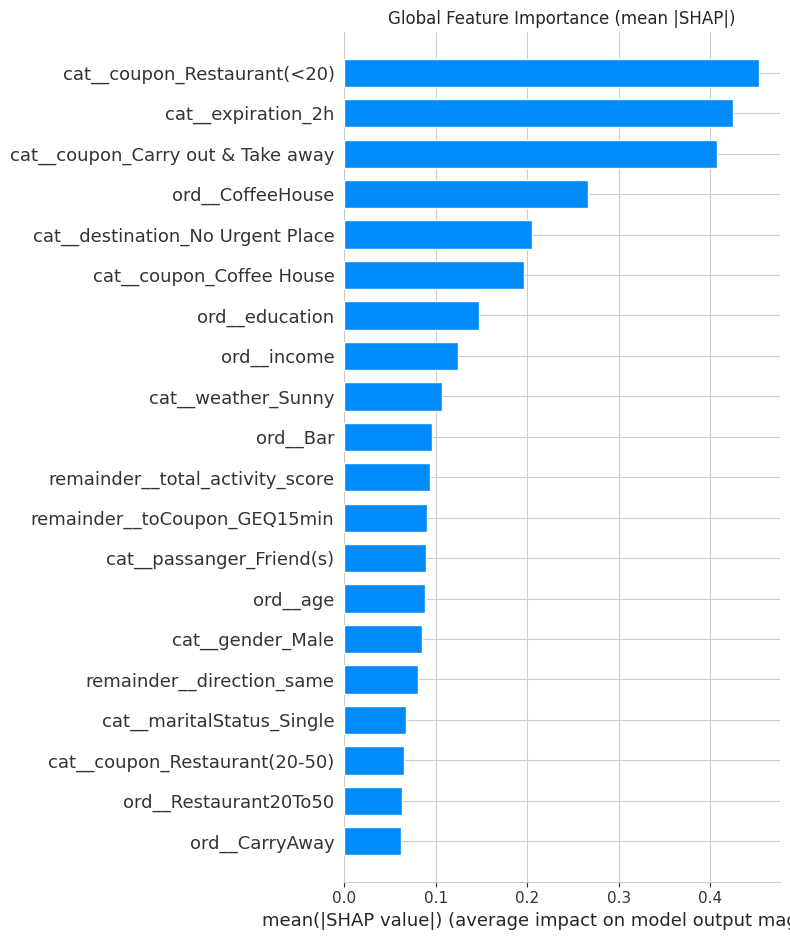

In [80]:
plt.figure()
shap.summary_plot(shap_plot, X_plot, feature_names=feature_names, plot_type="bar", show=False)
plt.title("Global Feature Importance (mean |SHAP|)")
plt.tight_layout()
plt.show()

---

### Key Takeaways from the Global Feature Importance Plot

The chart illustrates which features have the **largest average impact** on the model's predictions, measured by the **mean absolute SHAP value**.

---

#### Coupon and Expiration Are Critical
The most influential predictors are directly tied to the **coupon offer** and its **timing**.

- **`cat_coupon_Restaurant(<20)`** – Represents smaller, frequent-value restaurant coupons that strongly affect the likelihood of acceptance.  
- **`cat_expiration_2h`** – Short expiration times drive urgency and significantly increase acceptance probability.

These features show that **immediacy and value** dominate user decision-making.

---

#### Location Type Matters
Features capturing **establishment context** and offer type play a major role:

- **`ord_CoffeeHouse`** and **`cat_coupon_Carry out & Take away`** reflect how convenience-oriented offers (quick, nearby, casual options) appeal more to users.
  
This suggests the **environment of the offer** (e.g., coffee shop vs. restaurant) substantially shapes coupon response.

---

#### Contextual and Lifestyle Factors Have Moderate Influence
External and personal variables show a **middle-tier impact**:

- **`cat_weather_Sunny`**, **`ord_education`**, and **`ord_income`** influence acceptance modestly.  
  They capture situational readiness and socio-economic context but are **less dominant** than direct offer characteristics.

---

#### Demographics Are Least Influential
User demographics have the **lowest mean SHAP impact**, suggesting personalization by these attributes adds little value:

- **`cat_gender_Male`**, **`ord_age`**, and **`cat_maritalStatus_Single`** minimally affect predictions.

This means the model prioritizes **behavioral and contextual** variables over static demographic traits.

---

**Summary Insight:**  
The model’s decision-making is primarily driven by **offer-related and situational factors**, not user identity. Businesses can improve conversion rates by focusing on **time-sensitive, contextually relevant** offers rather than demographic segmentation.

---


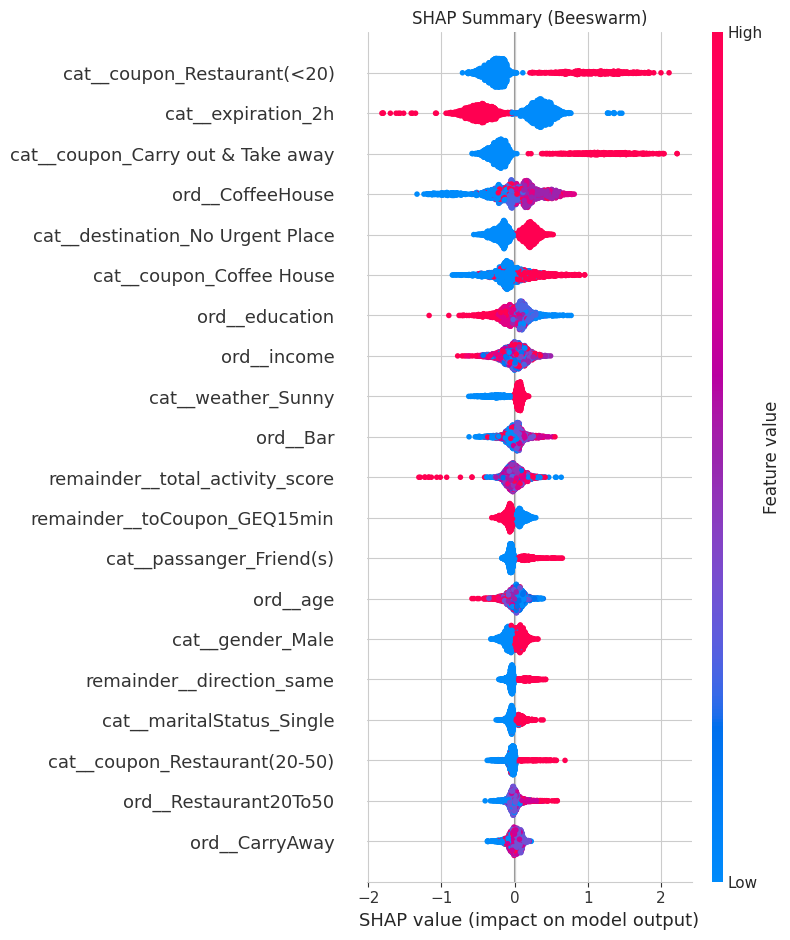

In [81]:
plt.figure()
shap.summary_plot(shap_plot, X_plot, feature_names=feature_names, show=False)
plt.title("SHAP Summary (Beeswarm)")
plt.tight_layout()
plt.show()

---

### SHAP Summary (Beeswarm) Interpretation

The SHAP Beeswarm plot shows how each feature influences individual predictions for coupon acceptance.  
Each point represents one observation:
- **Color:** Feature value (red = high, blue = low)  
- **Position:** SHAP value (horizontal impact on model output)

---

### Coupon Attributes Dominate

- **`cat__coupon_Restaurant(<20)`** and **`cat__expiration_2h`** have the strongest impact on predictions.  
  Short expiration times and small-value restaurant coupons significantly increase the probability of coupon acceptance.  
- High SHAP values on the right (in red) indicate that these feature values push predictions toward “accept”.

---

### Contextual Preferences Shape Behavior

- **`ord__CoffeeHouse`** and **`cat__coupon_Carry out & Take away`** are also influential.  
  This shows that users are more likely to accept coupons related to **casual or convenient environments**.  
- **`cat__destination_No Urgent Place`** suggests that people who are not in a rush are more open to redeeming offers.

---

### Situational and Socioeconomic Factors

- Moderate effects are observed for **`cat__weather_Sunny`**, **`ord__education`**, and **`ord__income`**.  
  These indicate that external conditions and socio-economic context influence behavior, but less strongly than the coupon’s attributes.

---

### Demographic Influence Is Minimal

- Features like **`cat__gender_Male`**, **`ord__age`**, and **`cat__maritalStatus_Single`** show little to no impact.  
  This suggests the model’s predictions are **not strongly driven by demographic data**, emphasizing behavioral and situational factors instead.

---

### Overall Insight

The model relies most on **offer-related and contextual features**, while **personal demographics contribute the least**.  
This implies that marketing strategies should prioritize **time-sensitive, relevant offers** over demographic targeting.


<Figure size 640x480 with 0 Axes>

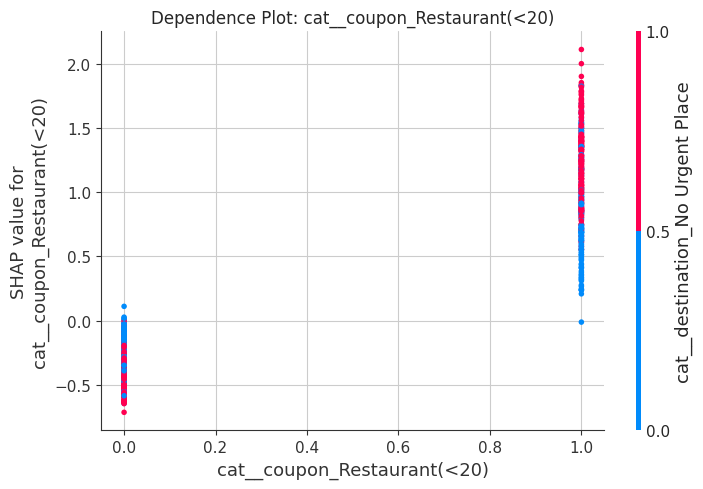

In [82]:
top_feature_index = int(np.argsort(np.mean(np.abs(shap_plot), axis=0))[-1])
plt.figure()
shap.dependence_plot(
    ind=top_feature_index,
    shap_values=shap_plot,
    features=X_plot,
    feature_names=feature_names,
    show=False
)
plt.title(f"Dependence Plot: {feature_names[top_feature_index]}")
plt.tight_layout()
plt.show()

---

### SHAP Dependence Plot Interpretation — `cat__coupon_Restaurant(<20)`

This dependence plot shows how the feature **`cat__coupon_Restaurant(<20)`** affects the model’s predicted probability of coupon acceptance, while also revealing interaction effects with **`cat__destination_No Urgent Place`** (shown by the color gradient).

---

### 1. Coupon Effect on Model Output

- The feature is **binary** (0 = coupon not offered, 1 = coupon offered).  
- When **`cat__coupon_Restaurant(<20)` = 1**, the **SHAP values are predominantly positive**, meaning that the presence of this coupon **strongly pushes predictions toward acceptance**.  
- When the feature is **absent (0)**, SHAP values cluster around **0 or slightly negative**, indicating minimal or negative contribution to acceptance.

**Conclusion:**  
Users are significantly more likely to accept a **Restaurant(<20)** coupon when it is available.

---

### 2. Interaction with Destination Context

- The color scale represents **`cat__destination_No Urgent Place`**, which indicates whether the person is not headed to an urgent location.
- **Red points (value = 1)**, corresponding to “No Urgent Place,” tend to have **higher SHAP values** when the coupon is active.  
  This implies that **users with flexible schedules are even more influenced** by the presence of this coupon.
- **Blue points (value = 0)**, representing users headed to a specific destination, show lower SHAP impacts, suggesting **reduced likelihood** of accepting coupons while en route to a goal-oriented location.

---

### 3. Behavioral Insight

This pattern highlights a **behavioral dependency**:
- People who are **not in a hurry** (no urgent place to reach) are **much more receptive** to small-value restaurant offers.
- It supports the idea that **situational flexibility** amplifies coupon effectiveness, especially for quick, inexpensive dining options.

---

**Summary:**  
The `Restaurant(<20)` coupon significantly drives acceptance, and its impact is magnified when users are not constrained by time or destination urgency. This interaction reinforces that **both offer type and situational context** jointly determine user response.


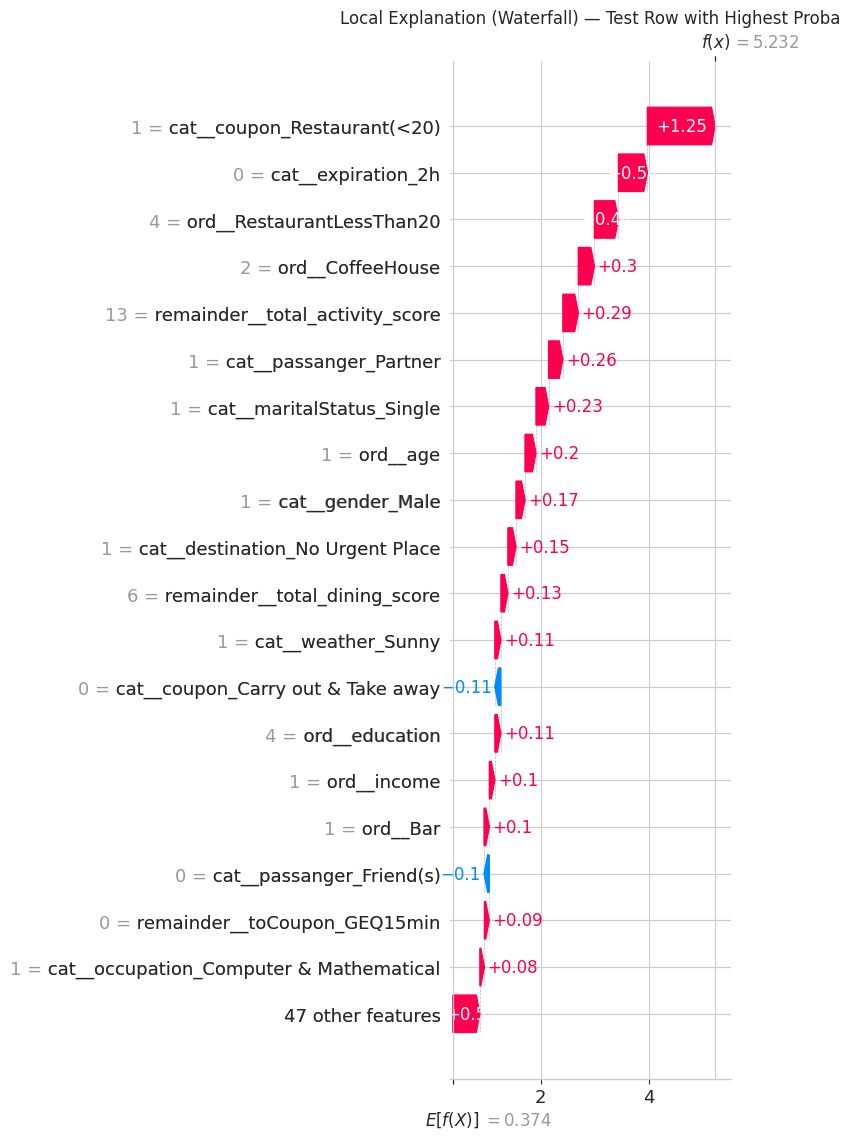

In [83]:
y_proba_test = final_xgb.predict_proba(X_test_processed)[:, 1]
row_ix = int(np.argmax(y_proba_test))

base = expected_value
values_row = shap_vals_pos[row_ix]
data_row = X_test_dense[row_ix]
expl_row = shap.Explanation(
    values=values_row,
    base_values=base,
    data=data_row,
    feature_names=feature_names
)

# Waterfall plot
plt.figure()
shap.plots.waterfall(expl_row, show=False, max_display=20)
plt.title("Local Explanation (Waterfall) — Test Row with Highest Proba")
plt.tight_layout()
plt.show()


shap.plots.force(expl_row)

---

### Local SHAP Explanation (Waterfall Plot) — Interpretation for Highest Probability Case

This **waterfall plot** shows how individual features contributed to the model’s **highest predicted probability** of accepting a coupon.  
Starting from the **expected base value (E[f(X)] = 0.374)**, each bar indicates how much a specific feature **increased (red)** or **decreased (blue)** the prediction until reaching the final output **f(X) = 5.232**.

---

### 1. Strongest Positive Contributors

These features had the **largest positive impact** on the model’s decision to predict coupon acceptance:

| Feature | Contribution | Interpretation |
|----------|---------------|----------------|
| **`cat__coupon_Restaurant(<20)`** | **+1.25** | The strongest positive influence — the user highly favors small-value restaurant coupons. |
| **`cat__expiration_2h`** | **+0.50** | A short expiration time likely created a sense of urgency, increasing acceptance likelihood. |
| **`ord__RestaurantLessThan20`** | **+0.40** | Frequent visits to affordable restaurants align with coupon interests. |
| **`ord__CoffeeHouse`** | **+0.30** | Regular coffeehouse visits further reinforce behavioral consistency in accepting casual offers. |
| **`remainder__total_activity_score`** | **+0.29** | High overall engagement in social and dining activities increases acceptance tendency. |

**Insight:**  
Behavioral and situational indicators — frequent dining, social activity, and urgency — are the main drivers pushing the prediction toward acceptance.

---

### 2. Secondary Positive Contributors

Other features with smaller but reinforcing positive effects include:
- **`cat__passanger_Partner` (+0.26)** – traveling with a partner likely encourages social consumption.  
- **`cat__maritalStatus_Single` (+0.23)** and **`ord__age` (+0.20)** – indicate openness to spontaneous decisions.  
- **`cat__gender_Male` (+0.17)** and **`cat__destination_No Urgent Place` (+0.15)** – reflect flexibility and availability for leisure.  
- **`cat__weather_Sunny` (+0.11)** – good weather slightly increases the likelihood of coupon usage.  

---

### 3. Negative Contributors

These features **slightly decreased** the probability of acceptance:

| Feature | Contribution | Interpretation |
|----------|---------------|----------------|
| **`cat__coupon_Carry out & Take away`** | **−0.11** | Suggests less interest in take-away offers compared to restaurant coupons. |
| **`cat__passanger_Friend(s)`** | **−0.10** | Being with friends might lead to shared decisions, reducing individual spontaneity. |
| **`remainder__toCoupon_GEQ15min`** | **−0.09** | Longer travel time slightly discourages coupon redemption. |

**Insight:**  
Negative SHAP values represent **mild deterrents** — mainly related to offer type and contextual inconvenience.

---

### 4. Overall Interpretation

The model’s final high prediction (**f(X) = 5.232**) was driven by:
- Strong alignment with **frequent dining and social behaviors**,  
- **Time-sensitive** coupon attributes,  
- And **favorable context** (good weather, leisure trip, presence of a partner).

Demographic and lifestyle factors (age, marital status, gender) provide additional support but are secondary to behavioral cues.

---

**Conclusion:**  
The model predicts a very high likelihood of coupon acceptance primarily due to **consistent behavioral patterns (frequent low-cost dining)** and **situational readiness (short expiration, leisure context)**.  
This highlights how **habitual behavior and contextual convenience** strongly shape user decisions.

---


In [ ]:
k = 100 if X_test_dense.shape[0] >= 100 else X_test_dense.shape[0]
top_idx = np.argsort(y_proba_test)[-k:]
cohort_mean_abs = np.mean(np.abs(shap_vals_pos[top_idx]), axis=0)
topk_feat_idx = np.argsort(cohort_mean_abs)[-15:][::-1]
print("\nTop 15 features for high-proba cohort:")
for i in topk_feat_idx:
    print(f"{feature_names[i]}  (mean|SHAP|={cohort_mean_abs[i]:.6f})")


Top 15 features for high-proba cohort:
cat__coupon_Restaurant(<20)  (mean|SHAP|=0.798100)
cat__expiration_2h  (mean|SHAP|=0.400972)
cat__coupon_Carry out & Take away  (mean|SHAP|=0.385999)
cat__destination_No Urgent Place  (mean|SHAP|=0.221956)
ord__CoffeeHouse  (mean|SHAP|=0.170842)
ord__education  (mean|SHAP|=0.142952)
cat__passanger_Friend(s)  (mean|SHAP|=0.113135)
remainder__total_activity_score  (mean|SHAP|=0.109289)
ord__income  (mean|SHAP|=0.108754)
cat__weather_Sunny  (mean|SHAP|=0.102554)
cat__coupon_Coffee House  (mean|SHAP|=0.094205)
ord__age  (mean|SHAP|=0.070235)
ord__Bar  (mean|SHAP|=0.065109)
num__temperature  (mean|SHAP|=0.064786)
cat__maritalStatus_Single  (mean|SHAP|=0.061334)
